In [1]:
import collections
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
%config InlineBackend.figure_format='retina'

# Immunogenicity

### CD4+ IFNr

In [24]:
CD4_COLS = ['CD4-1', 'CD4-2', 'CD4-3', 'SARS CoV-2 cd4 pep pool', 'Iab(+)']

immunogenicity_CD4_IFNr_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD4_IFNr.csv')

print(immunogenicity_CD4_IFNr_data.columns.values.tolist())

# Only retain columns relevant to CD4 peptides.
immunogenicity_CD4_IFNr_data = immunogenicity_CD4_IFNr_data.loc[:, ['Vaccine', 'ID']+CD4_COLS]

# Clip any values < 0.
for col in CD4_COLS:
    immunogenicity_CD4_IFNr_data[col] = immunogenicity_CD4_IFNr_data[col].clip(lower=0)

immunogenicity_CD4_IFNr_data

['Vaccine', 'ID', 'Iab(+)', 'CD4-1', 'CD4-2', 'CD4-3', 'ALL pep pool', 'SARS CoV-2 cd4 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD4-1,CD4-2,CD4-3,SARS CoV-2 cd4 pep pool,Iab(+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00040,0.00057,0.00000,0.00200,0.00000
1,Peptide/poly IC,Peptide/poly IC-2,0.00022,0.00101,0.00001,0.00062,0.00000
2,Peptide/poly IC,Peptide/poly IC-3,0.00001,0.00039,0.00039,0.00039,0.00020
3,Pfizer/BNT,BNT-1,0.00024,0.00024,0.00047,0.00120,0.00052
4,Pfizer/BNT,BNT-2,0.00033,0.00064,0.00032,0.00000,0.00099
5,Pfizer/BNT,BNT-3,0.00018,0.00000,0.00000,0.00000,0.00000
6,MIT,MIT-1,0.00061,0.00091,0.00000,0.00061,0.00000
7,MIT,MIT-2,0.00000,0.00090,0.00000,0.00000,0.00000
8,MIT,MIT-3,0.00000,0.00000,0.00000,0.00024,0.00000
9,PBS,PBS-1,0.00000,0.00002,0.00000,0.00022,0.00000


In [25]:
immunogenicity_CD4_IFNr_df_all = pd.melt(
    immunogenicity_CD4_IFNr_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD4_COLS,
)
immunogenicity_CD4_IFNr_df_all['value %'] = immunogenicity_CD4_IFNr_df_all['value'] * 100.

immunogenicity_CD4_IFNr_df_all.replace(to_replace={'SARS CoV-2 cd4 pep pool': 'CD4 pool', 'Iab(+)': 'IAb (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD4_IFNr_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                           count      mean median       std
Vaccine         variable                                   
MIT             CD4 pool       3  0.028333  0.024  0.030730
                CD4-1          3  0.020333  0.000  0.035218
                CD4-2          3  0.060333  0.090  0.052253
                CD4-3          3  0.000000  0.000  0.000000
                IAb (+)        3  0.000000  0.000  0.000000
PBS             CD4 pool       3  0.013667  0.019  0.011930
                CD4-1          3  0.013000  0.000  0.022517
                CD4-2          3  0.000667  0.000  0.001155
                CD4-3          3  0.020000  0.021  0.019519
                IAb (+)        3  0.013000  0.000  0.022517
Peptide/poly IC CD4 pool       3  0.100333  0.062  0.087077
                CD4-1          3  0.021000  0.022  0.019519
                CD4-2          3  0.065667  0.057  0.031896
                CD4-3          3  0.013333  0.001  0.022234
                IAb (+)        3  0.006667  0.000  0.011547
Pfizer/BNT      CD4 pool       3  0.040000  0.000  0.069282
                CD4-1          3  0.025000  0.024  0.007550
                CD4-2          3  0.029333  0.024  0.032332
                CD4-3          3  0.026333  0.032  0.024007
                IAb (+)        3  0.050333  0.052  0.049521

In [26]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD4_IFNr_df = immunogenicity_CD4_IFNr_df_all.loc[immunogenicity_CD4_IFNr_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD4_IFNr_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD4-1,0.00024,0.024
4,Pfizer/BNT,BNT-2,CD4-1,0.00033,0.033
5,Pfizer/BNT,BNT-3,CD4-1,0.00018,0.018
6,MIT,MIT-1,CD4-1,0.00061,0.061
7,MIT,MIT-2,CD4-1,0.00000,0.000
8,MIT,MIT-3,CD4-1,0.00000,0.000
9,PBS,PBS-1,CD4-1,0.00000,0.000
10,PBS,PBS-2,CD4-1,0.00000,0.000
11,PBS,PBS-3,CD4-1,0.00039,0.039
15,Pfizer/BNT,BNT-1,CD4-2,0.00024,0.024


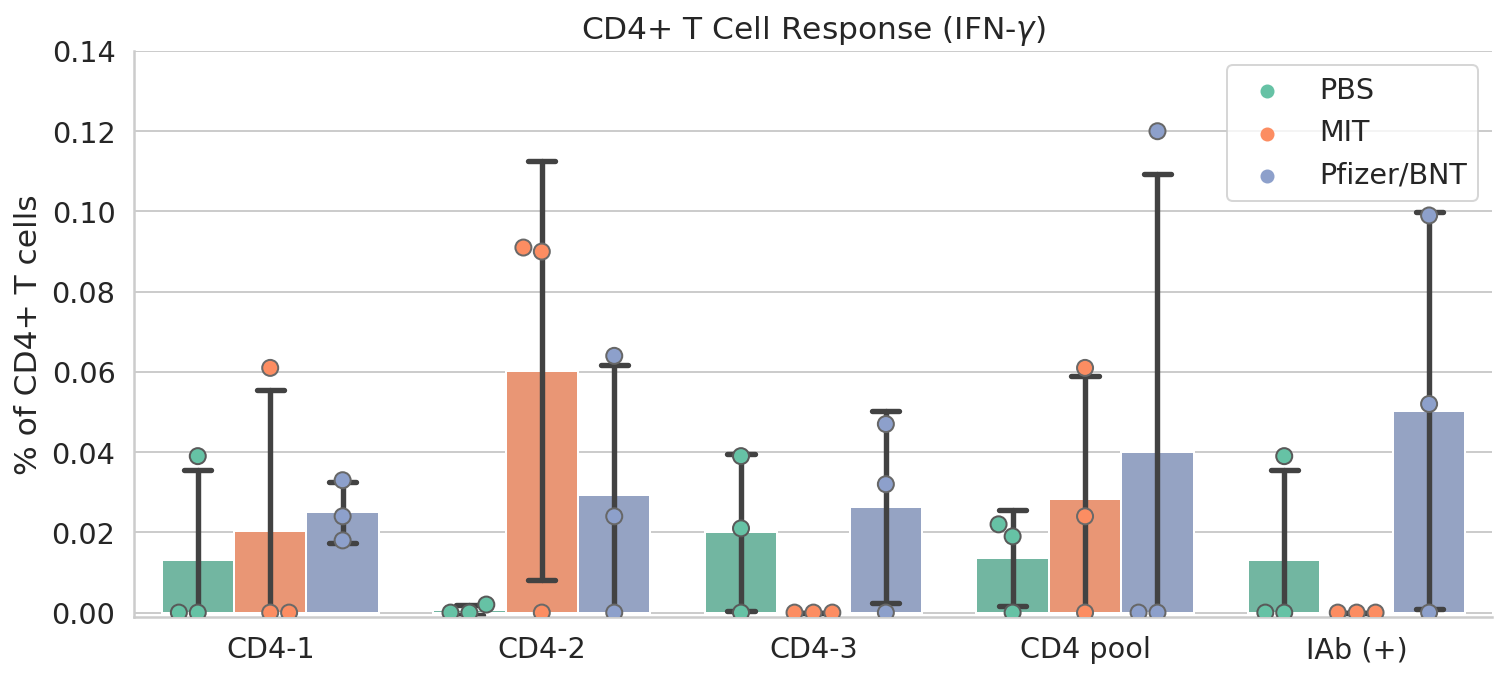

In [17]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD4_IFNr_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD4_IFNr_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([-0.001, 0.14])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD4+ T cells')
ax2.set_title(r'CD4+ T Cell Response (IFN-$\gamma$)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD4_IFNr.pdf')
plt.show()

In [18]:
# Compute statistics CD4+ / IFNr:

immunogenicity_data = immunogenicity_CD4_IFNr_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  9
Data PBS:  [0.0, 0.0, 0.039]
Data MIT:  [0.061, 0.0, 0.0]
Data Pfizer/BNT:  [0.023999999999999997, 0.033, 0.018000000000000002]
F_onewayResult(statistic=0.18252355440605952, pvalue=0.8376235599102329)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS  -0.0073    0.9 -0.0687  0.054  False
   MIT Pfizer/BNT   0.0047    0.9 -0.0567  0.066  False
   PBS Pfizer/BNT    0.012 0.8125 -0.0494 0.0734  False
-------------------------------------------------------


Statistics for query peptide:  CD4-2
Total data points (all groups):  9
Data PBS:  [0.002, 0.0, 0.0]
Data MIT:  [0.091, 0.09, 0.0]
Data Pfizer/BNT:  [0.023999999999999997, 0.064, 0.0]
F_onewayResult(statistic=2.121878033712823, pvalue=0.20094447361464837)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   mea

In [57]:
# Compute statistics CD4+ / IFNr (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD4_IFNr_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  12
Data PBS:  [0.0, 0.0, 0.039]
Data MIT:  [0.061, 0.0, 0.0]
Data Pfizer/BNT:  [0.023999999999999997, 0.033, 0.018000000000000002]
Data Peptide/poly IC:  [0.04, 0.022000000000000002, 0.001]
F_onewayResult(statistic=0.13727882855399637, pvalue=0.9349568373801351)
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------
            MIT             PBS  -0.0073   0.9 -0.0685 0.0538  False
            MIT Peptide/poly IC   0.0007   0.9 -0.0605 0.0618  False
            MIT      Pfizer/BNT   0.0047   0.9 -0.0565 0.0658  False
            PBS Peptide/poly IC    0.008   0.9 -0.0531 0.0691  False
            PBS      Pfizer/BNT    0.012   0.9 -0.0491 0.0731  False
Peptide/poly IC      Pfizer/BNT    0.004   0.9 -0.0571 0.0651  False
----------------------------------------------

### CD4+ TNFa

In [27]:
CD4_COLS = ['CD4-1', 'CD4-2', 'CD4-3', 'SARS CoV-2 cd4 pep pool', 'Iab(+)']

immunogenicity_CD4_TNFa_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD4_TNFa.csv')

print(immunogenicity_CD4_TNFa_data.columns.values.tolist())

# Clip any values < 0.
for col in CD4_COLS:
    immunogenicity_CD4_TNFa_data[col] = immunogenicity_CD4_TNFa_data[col].clip(lower=0)

# Only retain columns relevant to CD4 peptides.
immunogenicity_CD4_TNFa_data = immunogenicity_CD4_TNFa_data.loc[:, ['Vaccine', 'ID']+CD4_COLS]
immunogenicity_CD4_TNFa_data

['Vaccine', 'ID', 'Iab(+)', 'CD4-1', 'CD4-2', 'CD4-3', 'ALL pep pool', 'SARS CoV-2 cd4 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD4-1,CD4-2,CD4-3,SARS CoV-2 cd4 pep pool,Iab(+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00001,0.00000,0.00000,0.00000,0.00020
1,Peptide/poly IC,Peptide/poly IC-2,0.00000,0.00040,0.00000,0.00061,0.00020
2,Peptide/poly IC,Peptide/poly IC-3,0.00020,0.00019,0.00019,0.00000,0.00039
3,Pfizer/BNT,BNT-1,0.00000,0.00000,0.00000,0.00024,0.00026
4,Pfizer/BNT,BNT-2,0.00000,0.00032,0.00032,0.00033,0.00033
5,Pfizer/BNT,BNT-3,0.00023,0.00047,0.00000,0.00047,0.00047
6,MIT,MIT-1,0.00000,0.00170,0.00000,0.00090,0.00000
7,MIT,MIT-2,0.00025,0.00120,0.00000,0.00024,0.00000
8,MIT,MIT-3,0.00026,0.00025,0.00000,0.00076,0.00000
9,PBS,PBS-1,0.00021,0.00065,0.00064,0.00042,0.00000


In [28]:
immunogenicity_CD4_TNFa_df_all = pd.melt(
    immunogenicity_CD4_TNFa_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD4_COLS,
)
immunogenicity_CD4_TNFa_df_all['value %'] = immunogenicity_CD4_TNFa_df_all['value'] * 100.

immunogenicity_CD4_TNFa_df_all.replace(to_replace={'SARS CoV-2 cd4 pep pool': 'CD4 pool', 'Iab(+)': 'IAb (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD4_TNFa_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                           count      mean median       std
Vaccine         variable                                   
MIT             CD4 pool       3  0.063333  0.076  0.034775
                CD4-1          3  0.017000  0.025  0.014731
                CD4-2          3  0.105000  0.120  0.073655
                CD4-3          3  0.000000  0.000  0.000000
                IAb (+)        3  0.000000  0.000  0.000000
PBS             CD4 pool       3  0.014000  0.000  0.024249
                CD4-1          3  0.007000  0.000  0.012124
                CD4-2          3  0.021667  0.000  0.037528
                CD4-3          3  0.021333  0.000  0.036950
                IAb (+)        3  0.000000  0.000  0.000000
Peptide/poly IC CD4 pool       3  0.020333  0.000  0.035218
                CD4-1          3  0.007000  0.001  0.011269
                CD4-2          3  0.019667  0.019  0.020008
                CD4-3          3  0.006333  0.000  0.010970
                IAb (+)        3  0.026333  0.020  0.010970
Pfizer/BNT      CD4 pool       3  0.034667  0.033  0.011590
                CD4-1          3  0.007667  0.000  0.013279
                CD4-2          3  0.026333  0.032  0.024007
                CD4-3          3  0.010667  0.000  0.018475
                IAb (+)        3  0.035333  0.033  0.010693

In [29]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD4_TNFa_df = immunogenicity_CD4_TNFa_df_all.loc[immunogenicity_CD4_TNFa_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD4_TNFa_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD4-1,0.00000,0.000
4,Pfizer/BNT,BNT-2,CD4-1,0.00000,0.000
5,Pfizer/BNT,BNT-3,CD4-1,0.00023,0.023
6,MIT,MIT-1,CD4-1,0.00000,0.000
7,MIT,MIT-2,CD4-1,0.00025,0.025
8,MIT,MIT-3,CD4-1,0.00026,0.026
9,PBS,PBS-1,CD4-1,0.00021,0.021
10,PBS,PBS-2,CD4-1,0.00000,0.000
11,PBS,PBS-3,CD4-1,0.00000,0.000
15,Pfizer/BNT,BNT-1,CD4-2,0.00000,0.000


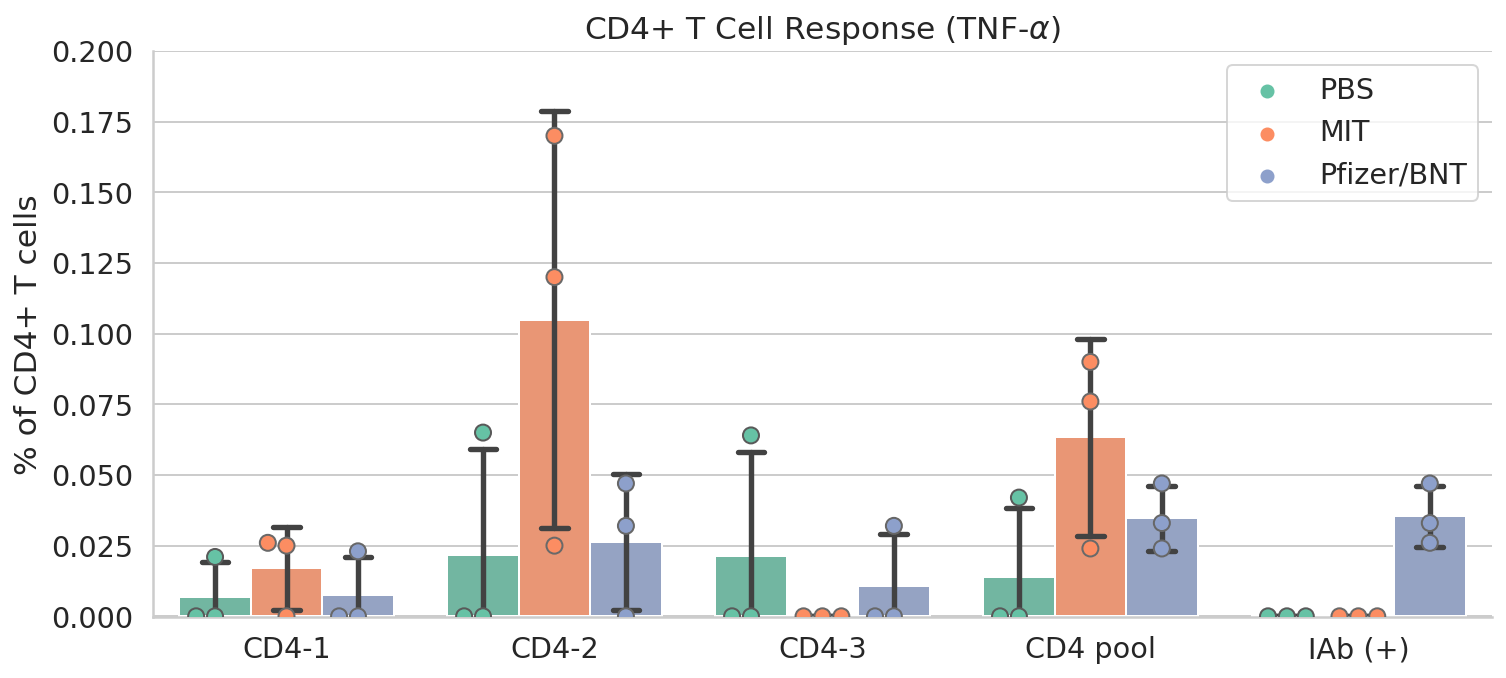

In [22]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD4_TNFa_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD4_TNFa_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([-0.0001, 0.2])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD4+ T cells')
ax2.set_title(r'CD4+ T Cell Response (TNF-$\alpha$)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD4_TNFa.pdf')
plt.show()

In [23]:
# Compute statistics CD4+ / TNFa:

immunogenicity_data = immunogenicity_CD4_TNFa_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  9
Data PBS:  [0.021, 0.0, 0.0]
Data MIT:  [0.0, 0.025, 0.026000000000000002]
Data Pfizer/BNT:  [0.0, 0.0, 0.023]
F_onewayResult(statistic=0.5206662553979026, pvalue=0.6187129285190013)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS    -0.01 0.6474 -0.0436 0.0236  False
   MIT Pfizer/BNT  -0.0093 0.6795 -0.0429 0.0242  False
   PBS Pfizer/BNT   0.0007    0.9 -0.0329 0.0342  False
-------------------------------------------------------


Statistics for query peptide:  CD4-2
Total data points (all groups):  9
Data PBS:  [0.065, 0.0, 0.0]
Data MIT:  [0.16999999999999998, 0.12, 0.025]
Data Pfizer/BNT:  [0.0, 0.032, 0.04700000000000001]
F_onewayResult(statistic=2.6630077826262983, pvalue=0.14866963963734553)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meand

In [58]:
# Compute statistics CD4+ / TNFa (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD4_TNFa_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  12
Data PBS:  [0.021, 0.0, 0.0]
Data MIT:  [0.0, 0.025, 0.026000000000000002]
Data Pfizer/BNT:  [0.0, 0.0, 0.023]
Data Peptide/poly IC:  [0.001, 0.0, 0.02]
F_onewayResult(statistic=0.4315684315684317, pvalue=0.736167242887884)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            MIT             PBS    -0.01 0.7627 -0.0438 0.0238  False
            MIT Peptide/poly IC    -0.01 0.7627 -0.0438 0.0238  False
            MIT      Pfizer/BNT  -0.0093  0.795 -0.0431 0.0244  False
            PBS Peptide/poly IC      0.0    0.9 -0.0338 0.0338  False
            PBS      Pfizer/BNT   0.0007    0.9 -0.0331 0.0344  False
Peptide/poly IC      Pfizer/BNT   0.0007    0.9 -0.0331 0.0344  False
---------------------------------------------------------------------


S

### CD4+ IL2

In [9]:
CD4_COLS = ['CD4-1', 'CD4-2', 'CD4-3', 'SARS CoV-2 cd4 pep pool', 'Iab(+)']

immunogenicity_CD4_IL2_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD4_IL2.csv')

print(immunogenicity_CD4_IL2_data.columns.values.tolist())

# Clip any values < 0.
for col in CD4_COLS:
    immunogenicity_CD4_IL2_data[col] = immunogenicity_CD4_IL2_data[col].clip(lower=0)

# Only retain columns relevant to CD4 peptides.
immunogenicity_CD4_IL2_data = immunogenicity_CD4_IL2_data.loc[:, ['Vaccine', 'ID']+CD4_COLS]
immunogenicity_CD4_IL2_data

['Vaccine', 'ID', 'Iab(+)', 'CD4-1', 'CD4-2', 'CD4-3', 'ALL pep pool', 'SARS CoV-2 cd4 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD4-1,CD4-2,CD4-3,SARS CoV-2 cd4 pep pool,Iab(+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00060,0.00077,0.00058,0.00079,0.00079
1,Peptide/poly IC,Peptide/poly IC-2,0.00001,0.00101,0.00001,0.00001,0.00000
2,Peptide/poly IC,Peptide/poly IC-3,0.00039,0.00038,0.00058,0.00019,0.00039
3,Pfizer/BNT,BNT-1,0.00000,0.00000,0.00000,0.00000,0.00005
4,Pfizer/BNT,BNT-2,0.00000,0.00000,0.00065,0.00066,0.00099
5,Pfizer/BNT,BNT-3,0.00000,0.00000,0.00000,0.00001,0.00000
6,MIT,MIT-1,0.00000,0.00250,0.00000,0.00110,0.00020
7,MIT,MIT-2,0.00000,0.00120,0.00000,0.00140,0.00000
8,MIT,MIT-3,0.00000,0.00000,0.00000,0.00000,0.00048
9,PBS,PBS-1,0.00042,0.00065,0.00042,0.00042,0.00000


In [10]:
immunogenicity_CD4_IL2_df_all = pd.melt(
    immunogenicity_CD4_IL2_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD4_COLS,
)
immunogenicity_CD4_IL2_df_all['value %'] = immunogenicity_CD4_IL2_df_all['value'] * 100.

immunogenicity_CD4_IL2_df_all.replace(to_replace={'SARS CoV-2 cd4 pep pool': 'CD4 pool', 'Iab(+)': 'IAb (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD4_IL2_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                           count      mean median       std
Vaccine         variable                                   
MIT             CD4 pool       3  0.083333  0.110  0.073711
                CD4-1          3  0.000000  0.000  0.000000
                CD4-2          3  0.123333  0.120  0.125033
                CD4-3          3  0.000000  0.000  0.000000
                IAb (+)        3  0.022667  0.020  0.024111
PBS             CD4 pool       3  0.014000  0.000  0.024249
                CD4-1          3  0.014000  0.000  0.024249
                CD4-2          3  0.021667  0.000  0.037528
                CD4-3          3  0.014000  0.000  0.024249
                IAb (+)        3  0.000000  0.000  0.000000
Peptide/poly IC CD4 pool       3  0.033000  0.019  0.040841
                CD4-1          3  0.033333  0.039  0.029905
                CD4-2          3  0.072000  0.077  0.031796
                CD4-3          3  0.039000  0.058  0.032909
                IAb (+)        3  0.039333  0.039  0.039501
Pfizer/BNT      CD4 pool       3  0.022333  0.001  0.037820
                CD4-1          3  0.000000  0.000  0.000000
                CD4-2          3  0.000000  0.000  0.000000
                CD4-3          3  0.021667  0.000  0.037528
                IAb (+)        3  0.034667  0.005  0.055770

In [11]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD4_IL2_df = immunogenicity_CD4_IL2_df_all.loc[immunogenicity_CD4_IL2_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD4_IL2_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD4-1,0.00000,0.000
4,Pfizer/BNT,BNT-2,CD4-1,0.00000,0.000
5,Pfizer/BNT,BNT-3,CD4-1,0.00000,0.000
6,MIT,MIT-1,CD4-1,0.00000,0.000
7,MIT,MIT-2,CD4-1,0.00000,0.000
8,MIT,MIT-3,CD4-1,0.00000,0.000
9,PBS,PBS-1,CD4-1,0.00042,0.042
10,PBS,PBS-2,CD4-1,0.00000,0.000
11,PBS,PBS-3,CD4-1,0.00000,0.000
15,Pfizer/BNT,BNT-1,CD4-2,0.00000,0.000


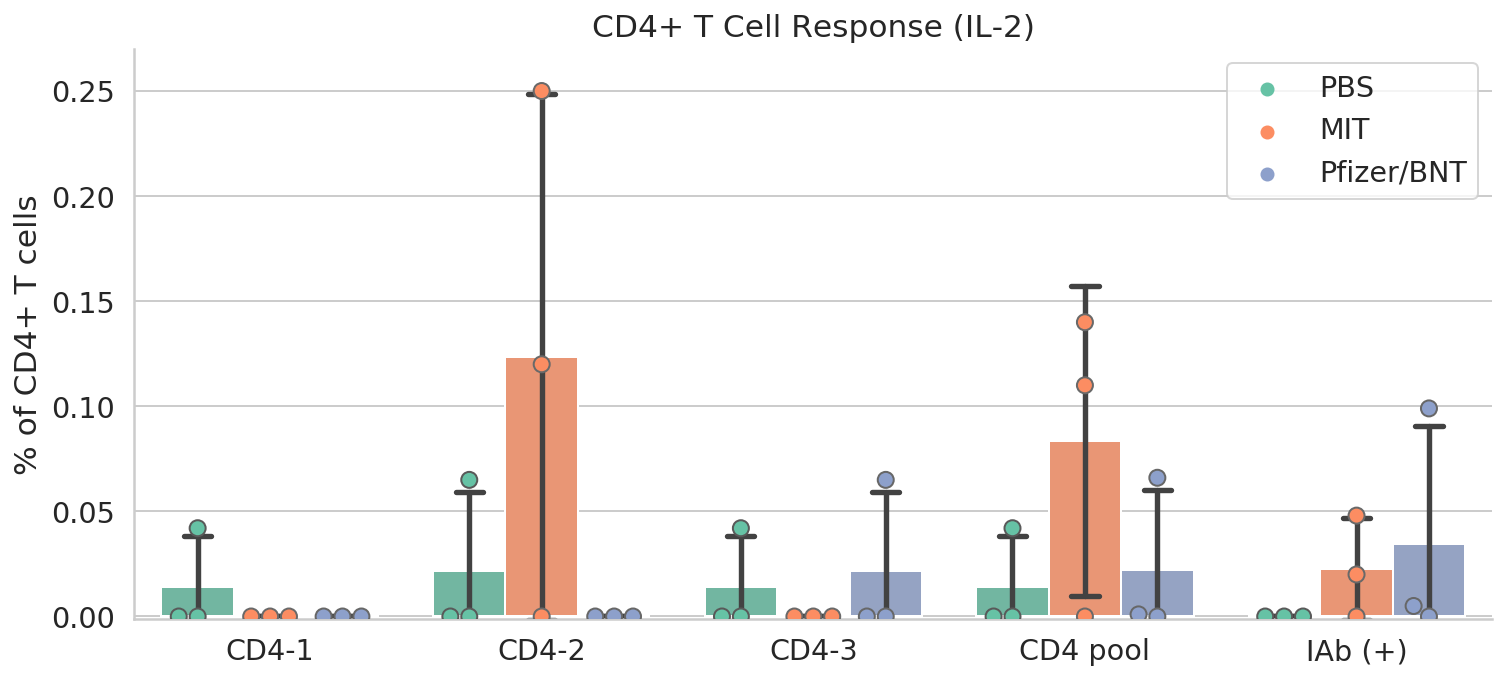

In [15]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD4_IL2_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD4_IL2_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([-0.001, 0.27])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD4+ T cells')
ax2.set_title(r'CD4+ T Cell Response (IL-2)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD4_IL2.pdf')
plt.show()

In [16]:
# Compute statistics CD4+ / IL2:

immunogenicity_data = immunogenicity_CD4_IL2_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  9
Data PBS:  [0.042, 0.0, 0.0]
Data MIT:  [0.0, 0.0, 0.0]
Data Pfizer/BNT:  [0.0, 0.0, 0.0]
F_onewayResult(statistic=1.0000000000000004, pvalue=0.421875)
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1   group2   meandiff p-adj  lower  upper reject
-----------------------------------------------------
   MIT        PBS    0.014 0.4836 -0.021 0.049  False
   MIT Pfizer/BNT      0.0    0.9 -0.035 0.035  False
   PBS Pfizer/BNT   -0.014 0.4836 -0.049 0.021  False
-----------------------------------------------------


Statistics for query peptide:  CD4-2
Total data points (all groups):  9
Data PBS:  [0.065, 0.0, 0.0]
Data MIT:  [0.25, 0.12, 0.0]
Data Pfizer/BNT:  [0.0, 0.0, 0.0]
F_onewayResult(statistic=2.289975550122249, pvalue=0.1823907334914595)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------

In [59]:
# Compute statistics CD4+ / IL2 (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD4_IL2_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4-1
Total data points (all groups):  12
Data PBS:  [0.042, 0.0, 0.0]
Data MIT:  [0.0, 0.0, 0.0]
Data Pfizer/BNT:  [0.0, 0.0, 0.0]
Data Peptide/poly IC:  [0.06, 0.001, 0.039]
F_onewayResult(statistic=2.015740948954351, pvalue=0.1903566400545518)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            MIT             PBS    0.014 0.7921 -0.0363 0.0643  False
            MIT Peptide/poly IC   0.0333 0.2255  -0.017 0.0837  False
            MIT      Pfizer/BNT      0.0    0.9 -0.0503 0.0503  False
            PBS Peptide/poly IC   0.0193 0.6185  -0.031 0.0697  False
            PBS      Pfizer/BNT   -0.014 0.7921 -0.0643 0.0363  False
Peptide/poly IC      Pfizer/BNT  -0.0333 0.2255 -0.0837  0.017  False
---------------------------------------------------------------------


Statistics for query

### CD8+ IFNr

In [30]:
CD8_COLS = ['CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8(-)-1', 'CD8(-)-2', 'CD4-2', 'SARS-CoV-2 cd8 pep pool', 'all pep pool', 'CD8 (+)']

immunogenicity_CD8_IFNr_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD8_IFNr.csv')

print(immunogenicity_CD8_IFNr_data.columns.values.tolist())

# Only retain columns relevant to CD8 peptides.
immunogenicity_CD8_IFNr_data = immunogenicity_CD8_IFNr_data.loc[:, ['Vaccine', 'ID']+CD8_COLS]

# Clip any values < 0.
for col in CD8_COLS:
    immunogenicity_CD8_IFNr_data[col] = immunogenicity_CD8_IFNr_data[col].clip(lower=0)

immunogenicity_CD8_IFNr_data

['Vaccine', 'ID', 'CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8 (+)', 'CD8(-)-1', 'CD8(-)-2', 'CD4-2', 'all pep pool', 'SARS-CoV-2 cd4 pep pool', 'SARS-CoV-2 cd8 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD8-1,CD8-2,CD8-3,CD8-4,CD8-5,CD8-6,CD8-7,CD8-8,CD8(-)-1,CD8(-)-2,CD4-2,SARS-CoV-2 cd8 pep pool,all pep pool,CD8 (+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00098,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00002,0.00228,0.00000
1,Peptide/poly IC,Peptide/poly IC-2,0.00046,0.00000,0.00000,0.00000,0.00000,0.00021,0.00000,0.00022,0.00000,0.00000,0.00000,0.00000,0.00024,0.00000
2,Peptide/poly IC,Peptide/poly IC-3,0.00025,0.00050,0.00024,0.00100,0.00051,0.00000,0.00049,0.00026,0.00025,0.00025,0.00050,0.00050,0.00050,0.00025
3,Pfizer/BNT,BNT-1,0.00000,0.00000,0.00001,0.00896,0.00000,0.00033,0.00021,0.00000,0.00000,0.00000,0.00000,0.00636,0.01036,0.00002
4,Pfizer/BNT,BNT-2,0.00062,0.00039,0.00038,0.00469,0.00000,0.00039,0.00000,0.00074,0.00040,0.00000,0.00000,0.01359,0.00609,0.00040
5,Pfizer/BNT,BNT-3,0.00000,0.00000,0.00000,0.00320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02790,0.00480,0.00000
6,MIT,MIT-1,0.00000,0.00000,0.00000,0.05498,0.00000,0.00024,0.00000,0.00000,0.00042,0.00042,0.00378,0.05588,0.07458,0.00000
7,MIT,MIT-2,0.00109,0.00020,0.00018,0.00919,0.00039,0.00169,0.00139,0.00060,0.00000,0.00040,0.02939,0.03019,0.06109,0.00000
8,MIT,MIT-3,0.00139,0.00149,0.00019,0.07449,0.00099,0.00229,0.00063,0.00019,0.00046,0.00046,0.01959,0.08439,0.11079,0.00041
9,PBS,PBS-1,0.00000,0.00000,0.00000,0.00045,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00022,0.00395,0.00000


In [31]:
immunogenicity_CD8_IFNr_df_all = pd.melt(
    immunogenicity_CD8_IFNr_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD8_COLS,
)
immunogenicity_CD8_IFNr_df_all['value %'] = immunogenicity_CD8_IFNr_df_all['value'] * 100.

immunogenicity_CD8_IFNr_df_all.replace(
    to_replace={'SARS-CoV-2 cd8 pep pool': 'CD8 pool', 'all pep pool': 'Pep pool', 'CD8 (+)': 'A0201 (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD8_IFNr_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                            count      mean median       std
Vaccine         variable                                    
MIT             A0201 (+)       3  0.013667  0.000  0.023671
                CD4-2           3  1.758667  1.959  1.292200
                CD8 pool        3  5.682000  5.588  2.711222
                CD8(-)-1        3  0.029333  0.042  0.025482
                CD8(-)-2        3  0.042667  0.042  0.003055
                CD8-1           3  0.082667  0.109  0.073146
                CD8-2           3  0.056333  0.020  0.080872
                CD8-3           3  0.012333  0.018  0.010693
                CD8-4           3  4.622000  5.498  3.351978
                CD8-5           3  0.046000  0.039  0.049870
                CD8-6           3  0.140667  0.169  0.105396
                CD8-7           3  0.067333  0.063  0.069601
                CD8-8           3  0.026333  0.019  0.030665
                Pep pool        3  8.215333  7.458  2.570095
PBS             A0201 (+)       3  0.015667  0.000  0.027135
                CD4-2           3  0.042333  0.032  0.048336
                CD8 pool        3  0.031000  0.022  0.036346
                CD8(-)-1        3  0.007667  0.000  0.013279
                CD8(-)-2        3  0.000000  0.000  0.000000
                CD8-1           3  0.000000  0.000  0.000000
                CD8-2           3  0.015667  0.000  0.027135
                CD8-3           3  0.008000  0.000  0.013856
                CD8-4           3  0.023000  0.024  0.022517
                CD8-5           3  0.031000  0.000  0.053694
                CD8-6           3  0.022667  0.000  0.039260
                CD8-7           3  0.030333  0.000  0.052539
                CD8-8           3  0.015667  0.000  0.027135
                Pep pool        3  0.147333  0.047  0.215769
Peptide/poly IC A0201 (+)       3  0.008333  0.000  0.014434
                CD4-2           3  0.016667  0.000  0.028868
                CD8 pool        3  0.017333  0.002  0.028308
                CD8(-)-1        3  0.008333  0.000  0.014434
                CD8(-)-2        3  0.008333  0.000  0.014434
                CD8-1           3  0.056333  0.046  0.037581
                CD8-2           3  0.016667  0.000  0.028868
                CD8-3           3  0.008000  0.000  0.013856
                CD8-4           3  0.033333  0.000  0.057735
                CD8-5           3  0.017000  0.000  0.029445
                CD8-6           3  0.007000  0.000  0.012124
                CD8-7           3  0.016333  0.000  0.028290
                CD8-8           3  0.016000  0.022  0.014000
                Pep pool        3  0.100667  0.050  0.111038
Pfizer/BNT      A0201 (+)       3  0.014000  0.002  0.022539
                CD4-2           3  0.000000  0.000  0.000000
                CD8 pool        3  1.595000  1.359  1.096221
                CD8(-)-1        3  0.013333  0.000  0.023094
                CD8(-)-2        3  0.000000  0.000  0.000000
                CD8-1           3  0.020667  0.000  0.035796
                CD8-2           3  0.013000  0.000  0.022517
                CD8-3           3  0.013000  0.001  0.021656
                CD8-4           3  0.561667  0.469  0.298972
                CD8-5           3  0.000000  0.000  0.000000
                CD8-6           3  0.024000  0.033  0.021000
                CD8-7           3  0.007000  0.000  0.012124
                CD8-8           3  0.024667  0.000  0.042724
                Pep pool        3  0.708333  0.609  0.291006

In [32]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD8_IFNr_df = immunogenicity_CD8_IFNr_df_all.loc[immunogenicity_CD8_IFNr_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD8_IFNr_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD8-1,0.00000,0.000
4,Pfizer/BNT,BNT-2,CD8-1,0.00062,0.062
5,Pfizer/BNT,BNT-3,CD8-1,0.00000,0.000
6,MIT,MIT-1,CD8-1,0.00000,0.000
7,MIT,MIT-2,CD8-1,0.00109,0.109
...,...,...,...,...,...
163,MIT,MIT-2,A0201 (+),0.00000,0.000
164,MIT,MIT-3,A0201 (+),0.00041,0.041
165,PBS,PBS-1,A0201 (+),0.00000,0.000
166,PBS,PBS-2,A0201 (+),0.00047,0.047


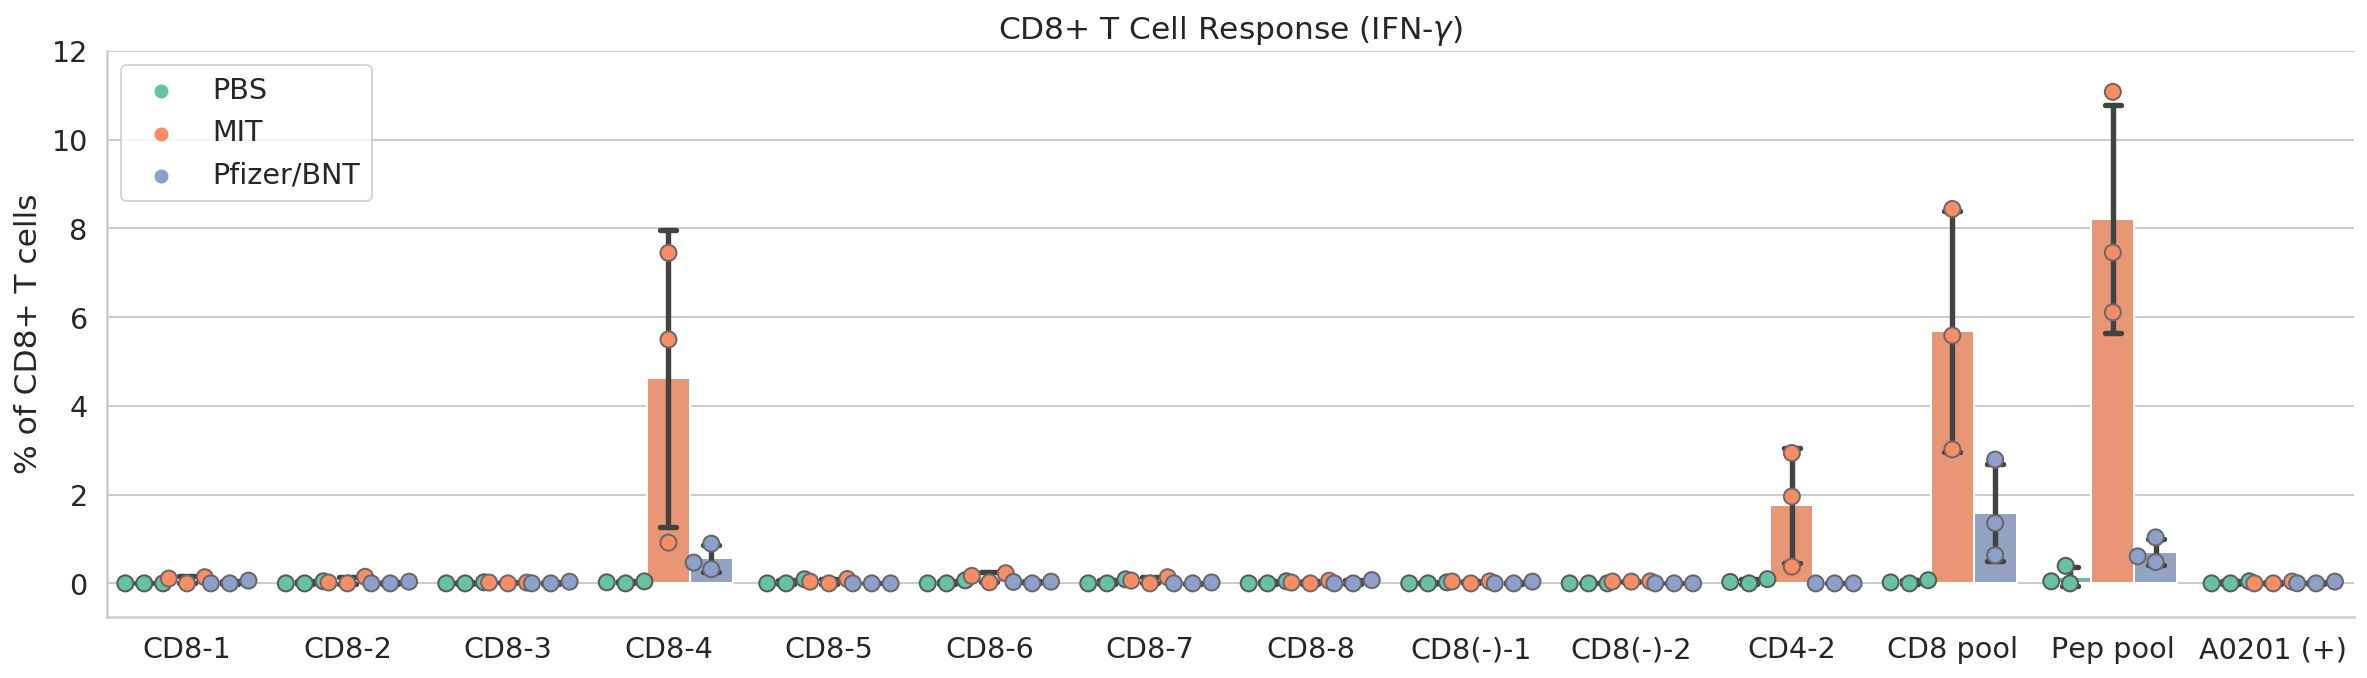

In [27]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD8_IFNr_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=3,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD8_IFNr_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([ax2.get_ylim()[0], 12])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD8+ T cells')
ax2.set_title(r'CD8+ T Cell Response (IFN-$\gamma$)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD8_IFNr.pdf')
plt.show()

In [28]:
# Compute statistics CD8+ / IFNr:

immunogenicity_data = immunogenicity_CD8_IFNr_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  9
Data PBS:  [0.0, 0.0, 0.0]
Data MIT:  [0.0, 0.109, 0.13899999999999998]
Data Pfizer/BNT:  [0.0, 0.062, 0.0]
F_onewayResult(statistic=2.5117868811259116, pvalue=0.16124509549469712)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS  -0.0827 0.1584 -0.2003  0.035  False
   MIT Pfizer/BNT   -0.062 0.3101 -0.1797 0.0557  False
   PBS Pfizer/BNT   0.0207 0.8446  -0.097 0.1383  False
-------------------------------------------------------


Statistics for query peptide:  CD8-2
Total data points (all groups):  9
Data PBS:  [0.0, 0.04700000000000001, 0.0]
Data MIT:  [0.0, 0.02, 0.149]
Data Pfizer/BNT:  [0.0, 0.039, 0.0]
F_onewayResult(statistic=0.6819408162391332, pvalue=0.5409203920373481)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  up

In [60]:
# Compute statistics CD8+ / IFNr (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD8_IFNr_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  12
Data PBS:  [0.0, 0.0, 0.0]
Data MIT:  [0.0, 0.109, 0.13899999999999998]
Data Pfizer/BNT:  [0.0, 0.062, 0.0]
Data Peptide/poly IC:  [0.098, 0.046, 0.025]
F_onewayResult(statistic=2.019379523730593, pvalue=0.18982956590344394)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            MIT             PBS  -0.0827 0.1876 -0.1999 0.0346  False
            MIT Peptide/poly IC  -0.0263 0.8798 -0.1436 0.0909  False
            MIT      Pfizer/BNT   -0.062  0.387 -0.1793 0.0553  False
            PBS Peptide/poly IC   0.0563 0.4615 -0.0609 0.1736  False
            PBS      Pfizer/BNT   0.0207    0.9 -0.0966 0.1379  False
Peptide/poly IC      Pfizer/BNT  -0.0357 0.7494 -0.1529 0.0816  False
---------------------------------------------------------------------




### CD8+ TNFa

In [33]:
CD8_COLS = ['CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8(-)-1', 'CD8(-)-2', 'CD4-2', 'SARS-CoV-2 cd8 pep pool', 'all pep pool', 'CD8 (+)']

immunogenicity_CD8_TNFa_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD8_TNFa.csv')

print(immunogenicity_CD8_TNFa_data.columns.values.tolist())

# Only retain columns relevant to CD8 peptides.
immunogenicity_CD8_TNFa_data = immunogenicity_CD8_TNFa_data.loc[:, ['Vaccine', 'ID']+CD8_COLS]

# Clip any values < 0.
for col in CD8_COLS:
    immunogenicity_CD8_TNFa_data[col] = immunogenicity_CD8_TNFa_data[col].clip(lower=0)

immunogenicity_CD8_TNFa_data

['Vaccine', 'ID', 'CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8 (+)', 'CD8(-)-1', 'CD8(-)-2', 'CD4-2', 'all pep pool', 'SARS-CoV-2 cd4 pep pool', 'SARS-CoV-2 cd8 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD8-1,CD8-2,CD8-3,CD8-4,CD8-5,CD8-6,CD8-7,CD8-8,CD8(-)-1,CD8(-)-2,CD4-2,SARS-CoV-2 cd8 pep pool,all pep pool,CD8 (+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00047,0.00024,0.00000,0.00001,0.00000,0.00024,0.00000,0.00025,0.00000,0.00000,0.00026,0.00025,0.00000,0.00000
1,Peptide/poly IC,Peptide/poly IC-2,0.00070,0.00000,0.00023,0.00023,0.00000,0.00068,0.00023,0.00046,0.00045,0.00023,0.00024,0.00000,0.00000,0.00000
2,Peptide/poly IC,Peptide/poly IC-3,0.00000,0.00025,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00026,0.00000,0.00000
3,Pfizer/BNT,BNT-1,0.00000,0.00000,0.00000,0.00128,0.00000,0.00004,0.00022,0.00000,0.00000,0.00000,0.00019,0.00168,0.00062,0.00000
4,Pfizer/BNT,BNT-2,0.00021,0.00020,0.00020,0.00076,0.00039,0.00000,0.00000,0.00019,0.00000,0.00000,0.00000,0.00370,0.00096,0.00020
5,Pfizer/BNT,BNT-3,0.00000,0.00000,0.00062,0.00218,0.00040,0.00000,0.00000,0.00043,0.00000,0.00000,0.00000,0.00648,0.00062,0.00043
6,MIT,MIT-1,0.00022,0.00021,0.00000,0.00730,0.00000,0.00000,0.00000,0.00020,0.00000,0.00000,0.00160,0.00520,0.00910,0.00021
7,MIT,MIT-2,0.00109,0.00020,0.00000,0.00099,0.00019,0.00000,0.00000,0.00000,0.00000,0.00000,0.00839,0.00499,0.01669,0.00020
8,MIT,MIT-3,0.00020,0.00120,0.00020,0.01620,0.00078,0.00045,0.00042,0.00040,0.00045,0.00022,0.00500,0.01580,0.02170,0.00021
9,PBS,PBS-1,0.00000,0.00063,0.00021,0.00022,0.00088,0.00045,0.00000,0.00021,0.00000,0.00000,0.00021,0.00021,0.00108,0.00022


In [34]:
immunogenicity_CD8_TNFa_df_all = pd.melt(
    immunogenicity_CD8_TNFa_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD8_COLS,
)
immunogenicity_CD8_TNFa_df_all['value %'] = immunogenicity_CD8_TNFa_df_all['value'] * 100.

immunogenicity_CD8_TNFa_df_all.replace(
    to_replace={'SARS-CoV-2 cd8 pep pool': 'CD8 pool', 'all pep pool': 'Pep pool', 'CD8 (+)': 'A0201 (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD8_TNFa_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                            count      mean median       std
Vaccine         variable                                    
MIT             A0201 (+)       3  0.020667  0.021  0.000577
                CD4-2           3  0.499667  0.500  0.339500
                CD8 pool        3  0.866333  0.520  0.618143
                CD8(-)-1        3  0.015000  0.000  0.025981
                CD8(-)-2        3  0.007333  0.000  0.012702
                CD8-1           3  0.050333  0.022  0.050817
                CD8-2           3  0.053667  0.021  0.057449
                CD8-3           3  0.006667  0.000  0.011547
                CD8-4           3  0.816333  0.730  0.764166
                CD8-5           3  0.032333  0.019  0.040673
                CD8-6           3  0.015000  0.000  0.025981
                CD8-7           3  0.014000  0.000  0.024249
                CD8-8           3  0.020000  0.020  0.020000
                Pep pool        3  1.583000  1.669  0.634387
PBS             A0201 (+)       3  0.023000  0.022  0.023516
                CD4-2           3  0.015000  0.021  0.013077
                CD8 pool        3  0.015000  0.021  0.013077
                CD8(-)-1        3  0.007667  0.000  0.013279
                CD8(-)-2        3  0.007667  0.000  0.013279
                CD8-1           3  0.015333  0.000  0.026558
                CD8-2           3  0.036667  0.047  0.032747
                CD8-3           3  0.015000  0.021  0.013077
                CD8-4           3  0.023000  0.022  0.023516
                CD8-5           3  0.052667  0.070  0.046490
                CD8-6           3  0.030000  0.045  0.025981
                CD8-7           3  0.015333  0.000  0.026558
                CD8-8           3  0.015000  0.021  0.013077
                Pep pool        3  0.043667  0.023  0.056889
Peptide/poly IC A0201 (+)       3  0.000000  0.000  0.000000
                CD4-2           3  0.016667  0.024  0.014468
                CD8 pool        3  0.017000  0.025  0.014731
                CD8(-)-1        3  0.015000  0.000  0.025981
                CD8(-)-2        3  0.007667  0.000  0.013279
                CD8-1           3  0.039000  0.047  0.035679
                CD8-2           3  0.016333  0.024  0.014154
                CD8-3           3  0.007667  0.000  0.013279
                CD8-4           3  0.008000  0.001  0.013000
                CD8-5           3  0.000000  0.000  0.000000
                CD8-6           3  0.030667  0.024  0.034487
                CD8-7           3  0.007667  0.000  0.013279
                CD8-8           3  0.023667  0.025  0.023029
                Pep pool        3  0.000000  0.000  0.000000
Pfizer/BNT      A0201 (+)       3  0.021000  0.020  0.021517
                CD4-2           3  0.006333  0.000  0.010970
                CD8 pool        3  0.395333  0.370  0.241001
                CD8(-)-1        3  0.000000  0.000  0.000000
                CD8(-)-2        3  0.000000  0.000  0.000000
                CD8-1           3  0.007000  0.000  0.012124
                CD8-2           3  0.006667  0.000  0.011547
                CD8-3           3  0.027333  0.020  0.031644
                CD8-4           3  0.140667  0.128  0.071842
                CD8-5           3  0.026333  0.039  0.022811
                CD8-6           3  0.001333  0.000  0.002309
                CD8-7           3  0.007333  0.000  0.012702
                CD8-8           3  0.020667  0.019  0.021548
                Pep pool        3  0.073333  0.062  0.019630

In [35]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD8_TNFa_df = immunogenicity_CD8_TNFa_df_all.loc[immunogenicity_CD8_TNFa_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD8_TNFa_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD8-1,0.00000,0.000
4,Pfizer/BNT,BNT-2,CD8-1,0.00021,0.021
5,Pfizer/BNT,BNT-3,CD8-1,0.00000,0.000
6,MIT,MIT-1,CD8-1,0.00022,0.022
7,MIT,MIT-2,CD8-1,0.00109,0.109
...,...,...,...,...,...
163,MIT,MIT-2,A0201 (+),0.00020,0.020
164,MIT,MIT-3,A0201 (+),0.00021,0.021
165,PBS,PBS-1,A0201 (+),0.00022,0.022
166,PBS,PBS-2,A0201 (+),0.00047,0.047


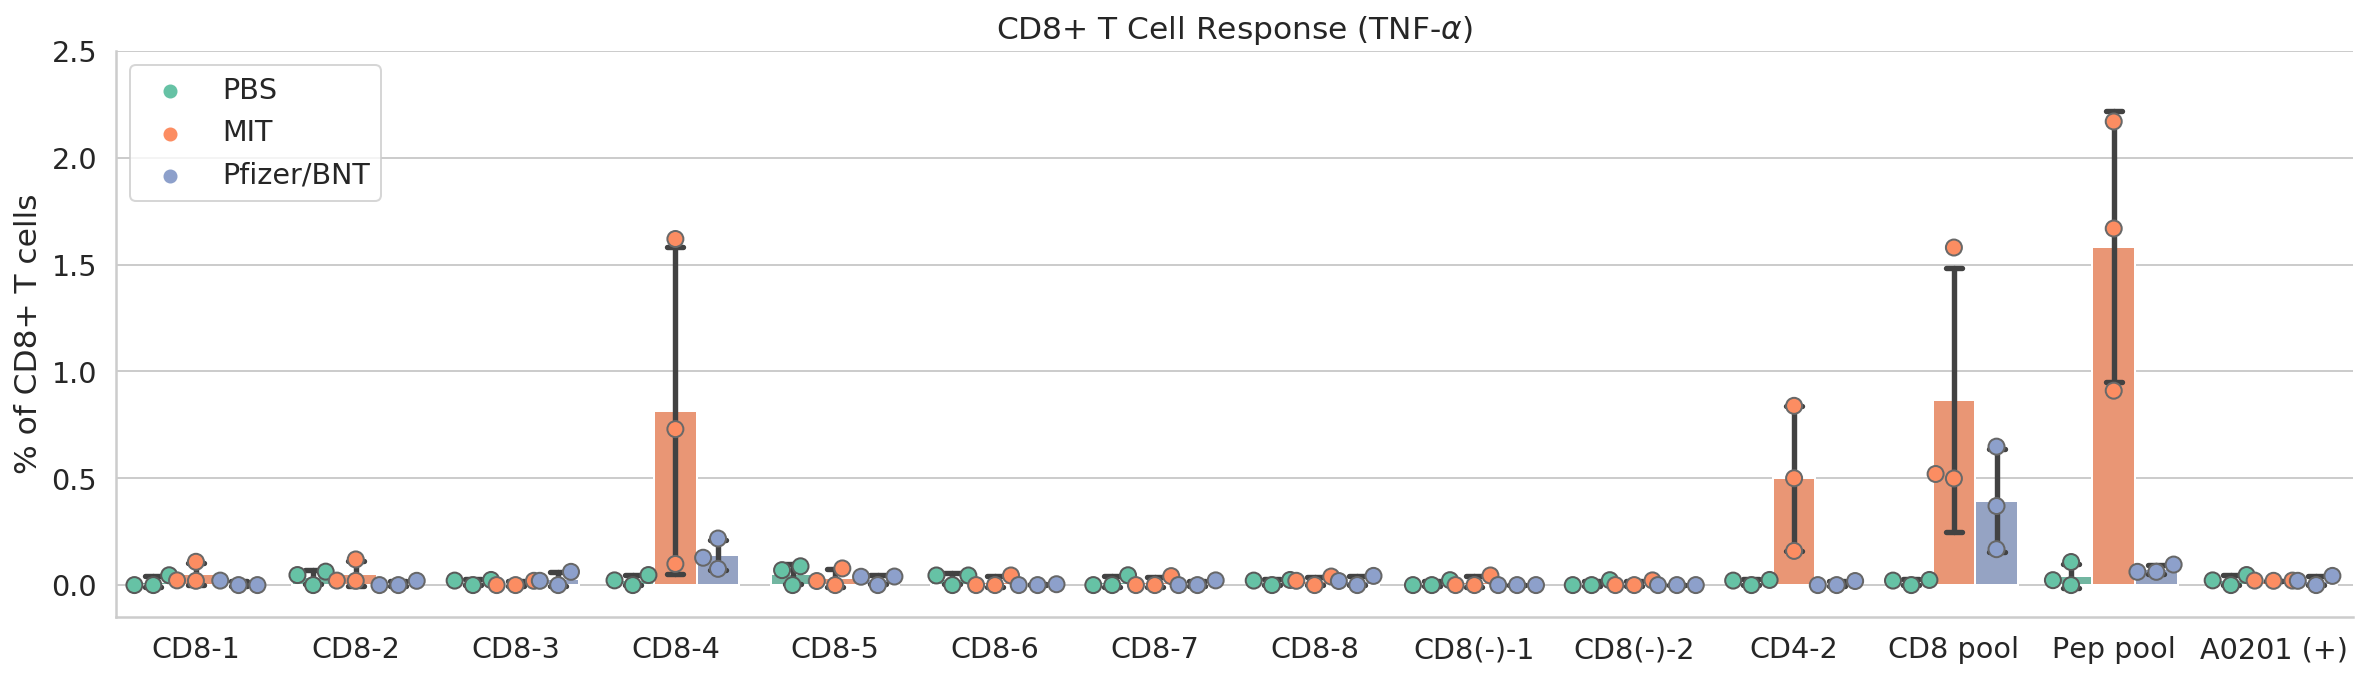

In [32]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD8_TNFa_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=3,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD8_TNFa_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([ax2.get_ylim()[0], 2.5])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD8+ T cells')
ax2.set_title(r'CD8+ T Cell Response (TNF-$\alpha$)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD8_TNFa.pdf')
plt.show()

In [33]:
# Compute statistics CD8+ / TNFa:

immunogenicity_data = immunogenicity_CD8_TNFa_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  9
Data PBS:  [0.0, 0.046, 0.0]
Data MIT:  [0.022000000000000002, 0.109, 0.02]
Data Pfizer/BNT:  [0.0, 0.021, 0.0]
F_onewayResult(statistic=1.3853843167701863, pvalue=0.32014062376181823)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS   -0.035 0.4626 -0.1197 0.0497  False
   MIT Pfizer/BNT  -0.0433 0.3278  -0.128 0.0413  False
   PBS Pfizer/BNT  -0.0083    0.9  -0.093 0.0763  False
-------------------------------------------------------


Statistics for query peptide:  CD8-2
Total data points (all groups):  9
Data PBS:  [0.063, 0.04700000000000001, 0.0]
Data MIT:  [0.021, 0.02, 0.12]
Data Pfizer/BNT:  [0.0, 0.02, 0.0]
F_onewayResult(statistic=1.131158455392809, pvalue=0.38295540602343714)
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1   group2   meandiff p-adj  lower 

In [61]:
# Compute statistics CD8+ / TNFa (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD8_TNFa_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  12
Data PBS:  [0.0, 0.046, 0.0]
Data MIT:  [0.022000000000000002, 0.109, 0.02]
Data Pfizer/BNT:  [0.0, 0.021, 0.0]
Data Peptide/poly IC:  [0.04700000000000001, 0.06999999999999999, 0.0]
F_onewayResult(statistic=1.0376218461611082, pvalue=0.42661701892499254)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            MIT             PBS   -0.035 0.6085 -0.1247 0.0547  False
            MIT Peptide/poly IC  -0.0113    0.9  -0.101 0.0784  False
            MIT      Pfizer/BNT  -0.0433 0.4573  -0.133 0.0464  False
            PBS Peptide/poly IC   0.0237 0.8155  -0.066 0.1134  False
            PBS      Pfizer/BNT  -0.0083    0.9  -0.098 0.0814  False
Peptide/poly IC      Pfizer/BNT   -0.032 0.6633 -0.1217 0.0577  False
-----------------------------------------

### CD8+ IL2

In [36]:
CD8_COLS = ['CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8(-)-1', 'CD8(-)-2', 'CD4-2', 'SARS-CoV-2 cd8 pep pool', 'all pep pool', 'CD8 (+)']

immunogenicity_CD8_IL2_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD8_IL2.csv')

print(immunogenicity_CD8_IL2_data.columns.values.tolist())

# Only retain columns relevant to CD8 peptides.
immunogenicity_CD8_IL2_data = immunogenicity_CD8_IL2_data.loc[:, ['Vaccine', 'ID']+CD8_COLS]

# Clip any values < 0.
for col in CD8_COLS:
    immunogenicity_CD8_IL2_data[col] = immunogenicity_CD8_IL2_data[col].clip(lower=0)

immunogenicity_CD8_IL2_data

['Vaccine', 'ID', 'CD8-1', 'CD8-2', 'CD8-3', 'CD8-4', 'CD8-5', 'CD8-6', 'CD8-7', 'CD8-8', 'CD8 (+)', 'CD4-2', 'CD8(-)-1', 'CD8(-)-2', 'all pep pool', 'SARS-CoV-2 cd4 pep pool', 'SARS-CoV-2 cd8 pep pool', 'PMA/ionoycin']


,Vaccine,ID,CD8-1,CD8-2,CD8-3,CD8-4,CD8-5,CD8-6,CD8-7,CD8-8,CD8(-)-1,CD8(-)-2,CD4-2,SARS-CoV-2 cd8 pep pool,all pep pool,CD8 (+)
0,Peptide/poly IC,Peptide/poly IC-1,0.00048,0.00000,0.00047,0.00049,0.00000,0.00024,0.00047,0.00049,0.00024,0.00024,0.00000,0.00000,0.00025,0.00000
1,Peptide/poly IC,Peptide/poly IC-2,0.00000,0.00000,0.00023,0.00000,0.00000,0.00022,0.00000,0.00000,0.00000,0.00023,0.00024,0.00000,0.00000,0.00046
2,Peptide/poly IC,Peptide/poly IC-3,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00125,0.00000,0.00000,0.00000,0.00000,0.00000
3,Pfizer/BNT,BNT-1,0.00021,0.00000,0.00001,0.00020,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00040,0.00078,0.00148,0.00024
4,Pfizer/BNT,BNT-2,0.00000,0.00000,0.00017,0.00034,0.00000,0.00000,0.00038,0.00000,0.00000,0.00020,0.00000,0.00208,0.00000,0.00000
5,Pfizer/BNT,BNT-3,0.00000,0.00000,0.00000,0.00088,0.00000,0.00022,0.00000,0.00043,0.00067,0.00021,0.00000,0.00458,0.00128,0.00022
6,MIT,MIT-1,0.00088,0.00000,0.00042,0.00278,0.00000,0.00002,0.00020,0.00000,0.00000,0.00000,0.00000,0.00278,0.00418,0.00021
7,MIT,MIT-2,0.00021,0.00000,0.00038,0.00020,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00065,0.00099,0.00259,0.00000
8,MIT,MIT-3,0.00000,0.00021,0.00020,0.00680,0.00019,0.00000,0.00063,0.00020,0.00000,0.00022,0.00100,0.00480,0.00610,0.00021
9,PBS,PBS-1,0.00022,0.00042,0.00022,0.00000,0.00022,0.00000,0.00021,0.00000,0.00022,0.00000,0.00021,0.00022,0.00065,0.00000


In [37]:
immunogenicity_CD8_IL2_df_all = pd.melt(
    immunogenicity_CD8_IL2_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=CD8_COLS,
)
immunogenicity_CD8_IL2_df_all['value %'] = immunogenicity_CD8_IL2_df_all['value'] * 100.

immunogenicity_CD8_IL2_df_all.replace(
    to_replace={'SARS-CoV-2 cd8 pep pool': 'CD8 pool', 'all pep pool': 'Pep pool', 'CD8 (+)': 'A0201 (+)'}, inplace=True)

# Compute mean/standard deviation of each group.
immunogenicity_CD8_IL2_df_all.groupby(['Vaccine', 'variable']).agg(['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                            count      mean median       std
Vaccine         variable                                    
MIT             A0201 (+)       3  0.014000  0.021  0.012124
                CD4-2           3  0.055000  0.065  0.050744
                CD8 pool        3  0.285667  0.278  0.190616
                CD8(-)-1        3  0.000000  0.000  0.000000
                CD8(-)-2        3  0.007333  0.000  0.012702
                CD8-1           3  0.036333  0.021  0.045960
                CD8-2           3  0.007000  0.000  0.012124
                CD8-3           3  0.033333  0.038  0.011719
                CD8-4           3  0.326000  0.278  0.332608
                CD8-5           3  0.006333  0.000  0.010970
                CD8-6           3  0.000667  0.000  0.001155
                CD8-7           3  0.027667  0.020  0.032192
                CD8-8           3  0.006667  0.000  0.011547
                Pep pool        3  0.429000  0.418  0.175758
PBS             A0201 (+)       3  0.000000  0.000  0.000000
                CD4-2           3  0.007333  0.001  0.011846
                CD8 pool        3  0.049000  0.022  0.066731
                CD8(-)-1        3  0.024000  0.022  0.025060
                CD8(-)-2        3  0.025000  0.000  0.043301
                CD8-1           3  0.023667  0.022  0.024542
                CD8-2           3  0.014000  0.000  0.024249
                CD8-3           3  0.023333  0.022  0.024028
                CD8-4           3  0.000000  0.000  0.000000
                CD8-5           3  0.015667  0.022  0.013650
                CD8-6           3  0.017333  0.000  0.030022
                CD8-7           3  0.007000  0.000  0.012124
                CD8-8           3  0.008000  0.000  0.013856
                Pep pool        3  0.037667  0.025  0.023692
Peptide/poly IC A0201 (+)       3  0.015333  0.000  0.026558
                CD4-2           3  0.008000  0.000  0.013856
                CD8 pool        3  0.000000  0.000  0.000000
                CD8(-)-1        3  0.049667  0.024  0.066335
                CD8(-)-2        3  0.015667  0.023  0.013577
                CD8-1           3  0.016000  0.000  0.027713
                CD8-2           3  0.000000  0.000  0.000000
                CD8-3           3  0.023333  0.023  0.023502
                CD8-4           3  0.016667  0.001  0.028006
                CD8-5           3  0.000000  0.000  0.000000
                CD8-6           3  0.015333  0.022  0.013317
                CD8-7           3  0.015667  0.000  0.027135
                CD8-8           3  0.016333  0.000  0.028290
                Pep pool        3  0.008333  0.000  0.014434
Pfizer/BNT      A0201 (+)       3  0.015333  0.022  0.013317
                CD4-2           3  0.013333  0.000  0.023094
                CD8 pool        3  0.248000  0.208  0.193132
                CD8(-)-1        3  0.022333  0.000  0.038682
                CD8(-)-2        3  0.013667  0.020  0.011846
                CD8-1           3  0.007000  0.000  0.012124
                CD8-2           3  0.000000  0.000  0.000000
                CD8-3           3  0.006000  0.001  0.009539
                CD8-4           3  0.047333  0.034  0.035907
                CD8-5           3  0.000000  0.000  0.000000
                CD8-6           3  0.007333  0.000  0.012702
                CD8-7           3  0.012667  0.000  0.021939
                CD8-8           3  0.014333  0.000  0.024826
                Pep pool        3  0.092000  0.128  0.080299

In [38]:
# Remove Peptide/poly IC for plot/statistics.
immunogenicity_CD8_IL2_df = immunogenicity_CD8_IL2_df_all.loc[immunogenicity_CD8_IL2_df_all['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]
immunogenicity_CD8_IL2_df

,Vaccine,ID,variable,value,value %
3,Pfizer/BNT,BNT-1,CD8-1,0.00021,0.021
4,Pfizer/BNT,BNT-2,CD8-1,0.00000,0.000
5,Pfizer/BNT,BNT-3,CD8-1,0.00000,0.000
6,MIT,MIT-1,CD8-1,0.00088,0.088
7,MIT,MIT-2,CD8-1,0.00021,0.021
...,...,...,...,...,...
163,MIT,MIT-2,A0201 (+),0.00000,0.000
164,MIT,MIT-3,A0201 (+),0.00021,0.021
165,PBS,PBS-1,A0201 (+),0.00000,0.000
166,PBS,PBS-2,A0201 (+),0.00000,0.000


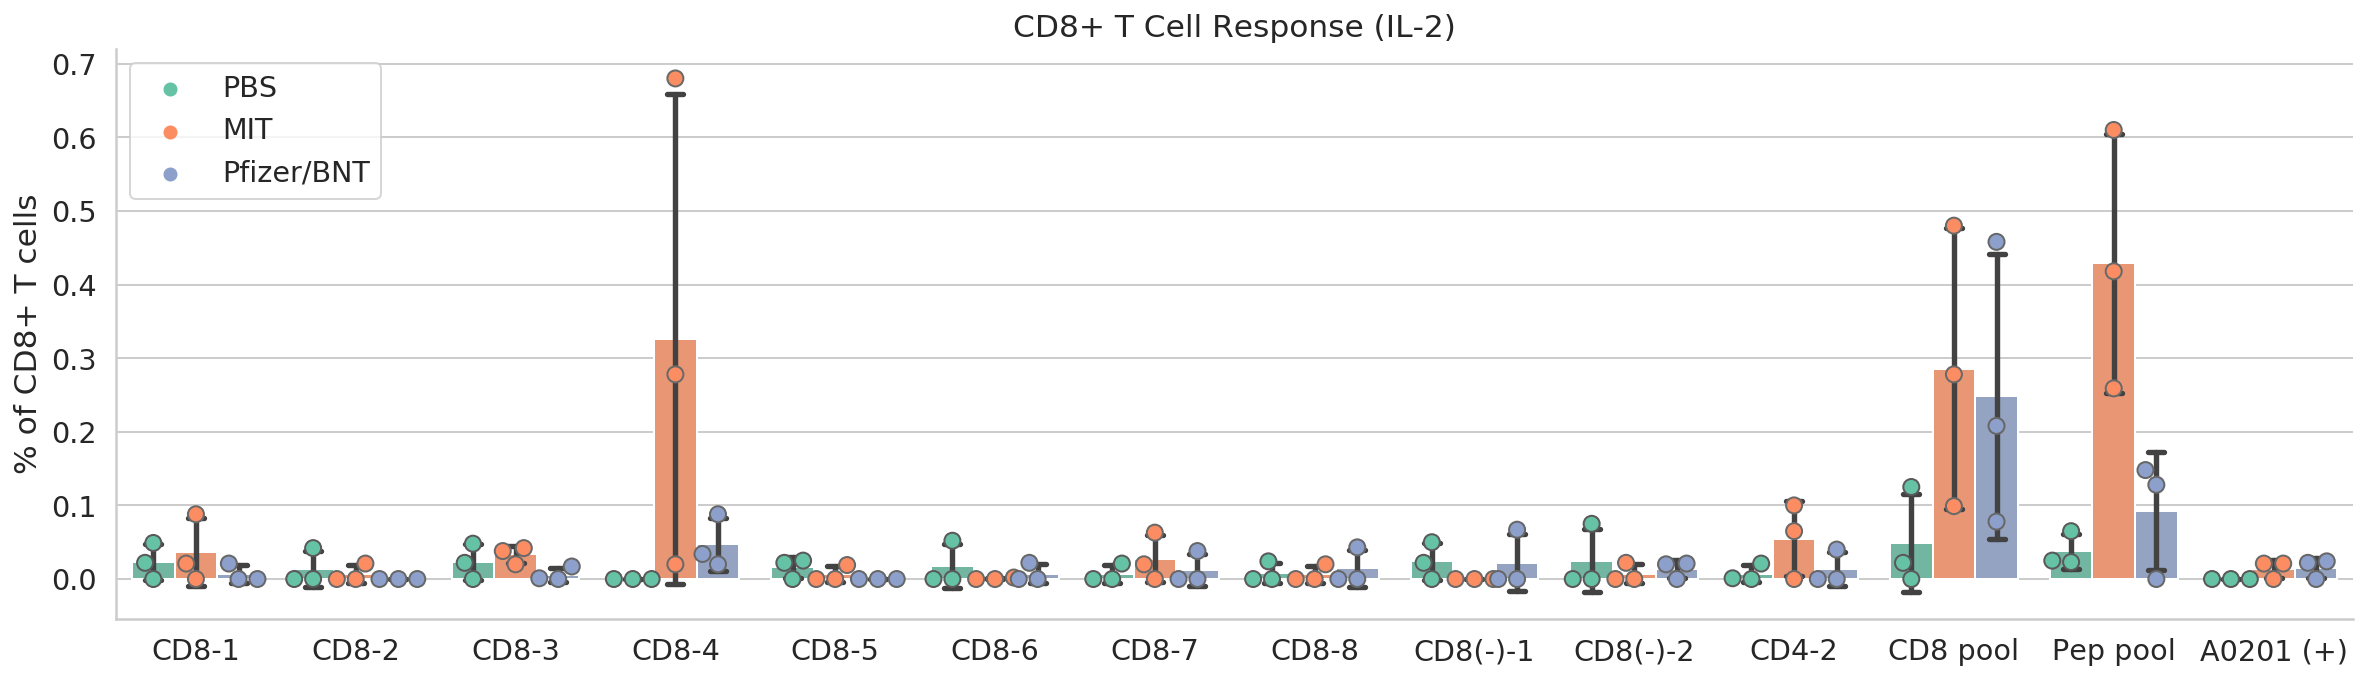

In [19]:
sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD8_IL2_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    errorbar='sd',
    aspect=3,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:3],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD8_IL2_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:3],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([ax2.get_ylim()[0], 0.72])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD8+ T cells')
ax2.set_title(r'CD8+ T Cell Response (IL-2)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD8_IL2.pdf')
plt.show()

In [7]:
# Compute statistics CD8+ / IL2:

immunogenicity_data = immunogenicity_CD8_IL2_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  9
Data PBS:  [0.022000000000000002, 0.0, 0.049]
Data MIT:  [0.08800000000000001, 0.021, 0.0]
Data Pfizer/BNT:  [0.021, 0.0, 0.0]
F_onewayResult(statistic=0.6807221898660456, pvalue=0.5414578393825594)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS  -0.0127 0.8636   -0.09 0.0646  False
   MIT Pfizer/BNT  -0.0293 0.5153 -0.1066  0.048  False
   PBS Pfizer/BNT  -0.0167   0.78  -0.094 0.0606  False
-------------------------------------------------------


Statistics for query peptide:  CD8-2
Total data points (all groups):  9
Data PBS:  [0.042, 0.0, 0.0]
Data MIT:  [0.0, 0.0, 0.021]
Data Pfizer/BNT:  [0.0, 0.0, 0.0]
F_onewayResult(statistic=0.6000000000000002, pvalue=0.5787037037037035)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  u

In [62]:
# Compute statistics CD8+ / IL2 (with Peptide/polyIC):

immunogenicity_data = immunogenicity_CD8_IL2_df_all

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_peptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_peptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_peptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD8-1
Total data points (all groups):  12
Data PBS:  [0.022000000000000002, 0.0, 0.049]
Data MIT:  [0.08800000000000001, 0.021, 0.0]
Data Pfizer/BNT:  [0.021, 0.0, 0.0]
Data Peptide/poly IC:  [0.047999999999999994, 0.0, 0.0]
F_onewayResult(statistic=0.5102090794991887, pvalue=0.6863072845005915)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            MIT             PBS  -0.0127    0.9 -0.0914 0.0661  False
            MIT Peptide/poly IC  -0.0203 0.8248 -0.0991 0.0584  False
            MIT      Pfizer/BNT  -0.0293 0.6376 -0.1081 0.0494  False
            PBS Peptide/poly IC  -0.0077    0.9 -0.0864 0.0711  False
            PBS      Pfizer/BNT  -0.0167    0.9 -0.0954 0.0621  False
Peptide/poly IC      Pfizer/BNT   -0.009    0.9 -0.0878 0.0698  False
------------------------------------------

# Peptide/poly IC Immunogenicity

In [39]:
# Create combined table of CD4/CD8 and IFNr/TNFa for a single supplemental figure.

immunogenicity_CD4_TNFa_df_peppolyic = immunogenicity_CD4_TNFa_df_all.loc[immunogenicity_CD4_TNFa_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD4_TNFa_df_peppolyic['CD8/CD4'] = 'CD4'
immunogenicity_CD4_TNFa_df_peppolyic['IFNr/TNFa'] = 'TNFa'

immunogenicity_CD4_IFNr_df_peppolyic = immunogenicity_CD4_IFNr_df_all.loc[immunogenicity_CD4_IFNr_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD4_IFNr_df_peppolyic['CD8/CD4'] = 'CD4'
immunogenicity_CD4_IFNr_df_peppolyic['IFNr/TNFa'] = 'IFNr'

immunogenicity_CD8_TNFa_df_peppolyic = immunogenicity_CD8_TNFa_df_all.loc[immunogenicity_CD8_TNFa_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD8_TNFa_df_peppolyic['CD8/CD4'] = 'CD8'
immunogenicity_CD8_TNFa_df_peppolyic['IFNr/TNFa'] = 'TNFa'

immunogenicity_CD8_IFNr_df_peppolyic = immunogenicity_CD8_IFNr_df_all.loc[immunogenicity_CD8_IFNr_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD8_IFNr_df_peppolyic['CD8/CD4'] = 'CD8'
immunogenicity_CD8_IFNr_df_peppolyic['IFNr/TNFa'] = 'IFNr'

immunogenicity_combined_peppolyic = pd.concat([
    immunogenicity_CD4_IFNr_df_peppolyic,
    immunogenicity_CD4_TNFa_df_peppolyic,
    immunogenicity_CD8_IFNr_df_peppolyic,
    immunogenicity_CD8_TNFa_df_peppolyic,
])
immunogenicity_combined_peppolyic

,Vaccine,ID,variable,value,value %,CD8/CD4,IFNr/TNFa
0,Peptide/poly IC,Peptide/poly IC-1,CD4-1,0.00040,0.040,CD4,IFNr
1,Peptide/poly IC,Peptide/poly IC-2,CD4-1,0.00022,0.022,CD4,IFNr
2,Peptide/poly IC,Peptide/poly IC-3,CD4-1,0.00001,0.001,CD4,IFNr
12,Peptide/poly IC,Peptide/poly IC-1,CD4-2,0.00057,0.057,CD4,IFNr
13,Peptide/poly IC,Peptide/poly IC-2,CD4-2,0.00101,0.101,CD4,IFNr
...,...,...,...,...,...,...,...
145,Peptide/poly IC,Peptide/poly IC-2,Pep pool,0.00000,0.000,CD8,TNFa
146,Peptide/poly IC,Peptide/poly IC-3,Pep pool,0.00000,0.000,CD8,TNFa
156,Peptide/poly IC,Peptide/poly IC-1,A0201 (+),0.00000,0.000,CD8,TNFa
157,Peptide/poly IC,Peptide/poly IC-2,A0201 (+),0.00000,0.000,CD8,TNFa


In [56]:
immunogenicity_combined_peppolyic.groupby(['CD8/CD4', 'IFNr/TNFa', 'Vaccine', 'variable']).agg(
    ['count', 'mean', 'median', 'std'])[['value %']]

value %                           
                                              count      mean median       std
CD8/CD4 IFNr/TNFa Vaccine         variable                                    
CD4     IFNr      Peptide/poly IC CD4 pool        3  0.100333  0.062  0.087077
                                  CD4-1           3  0.021000  0.022  0.019519
                                  CD4-2           3  0.065667  0.057  0.031896
                                  CD4-3           3  0.013333  0.001  0.022234
                                  IAb (+)         3  0.006667  0.000  0.011547
        TNFa      Peptide/poly IC CD4 pool        3  0.020333  0.000  0.035218
                                  CD4-1           3  0.007000  0.001  0.011269
                                  CD4-2           3  0.019667  0.019  0.020008
                                  CD4-3           3  0.006333  0.000  0.010970
                                  IAb (+)         3  0.026333  0.020  0.010970
CD8     IFNr      Peptide/poly IC A0201 (+)       3  0.008333  0.000  0.014434
                                  CD4-2           3  0.016667  0.000  0.028868
                                  CD8 pool        3  0.017333  0.002  0.028308
                                  CD8(-)-1        3  0.008333  0.000  0.014434
                                  CD8(-)-2        3  0.008333  0.000  0.014434
                                  CD8-1           3  0.056333  0.046  0.037581
                                  CD8-2           3  0.016667  0.000  0.028868
                                  CD8-3           3  0.008000  0.000  0.013856
                                  CD8-4           3  0.033333  0.000  0.057735
                                  CD8-5           3  0.017000  0.000  0.029445
                                  CD8-6           3  0.007000  0.000  0.012124
                                  CD8-7           3  0.016333  0.000  0.028290
                                  CD8-8           3  0.016000  0.022  0.014000
                                  Pep pool        3  0.100667  0.050  0.111038
        TNFa      Peptide/poly IC A0201 (+)       3  0.000000  0.000  0.000000
                                  CD4-2           3  0.016667  0.024  0.014468
                                  CD8 pool        3  0.017000  0.025  0.014731
                                  CD8(-)-1        3  0.015000  0.000  0.025981
                                  CD8(-)-2        3  0.007667  0.000  0.013279
                                  CD8-1           3  0.039000  0.047  0.035679
                                  CD8-2           3  0.016333  0.024  0.014154
                                  CD8-3           3  0.007667  0.000  0.013279
                                  CD8-4           3  0.008000  0.001  0.013000
                                  CD8-5           3  0.000000  0.000  0.000000
                                  CD8-6           3  0.030667  0.024  0.034487
                                  CD8-7           3  0.007667  0.000  0.013279
                                  CD8-8           3  0.023667  0.025  0.023029
                                  Pep pool        3  0.000000  0.000  0.000000

In [57]:
# Add LaTeX formatting for IFNr/TNFa
immunogenicity_combined_peppolyic_forplot = immunogenicity_combined_peppolyic.copy()
immunogenicity_combined_peppolyic_forplot['IFNr/TNFa'] = immunogenicity_combined_peppolyic_forplot['IFNr/TNFa'].replace(
    {'TNFa': r'TNF-$\alpha$', 'IFNr': r'IFN-$\gamma$'})
immunogenicity_combined_peppolyic_forplot

,Vaccine,ID,variable,value,value %,CD8/CD4,IFNr/TNFa
0,Peptide/poly IC,Peptide/poly IC-1,CD4-1,0.00040,0.040,CD4,IFN-$\gamma$
1,Peptide/poly IC,Peptide/poly IC-2,CD4-1,0.00022,0.022,CD4,IFN-$\gamma$
2,Peptide/poly IC,Peptide/poly IC-3,CD4-1,0.00001,0.001,CD4,IFN-$\gamma$
12,Peptide/poly IC,Peptide/poly IC-1,CD4-2,0.00057,0.057,CD4,IFN-$\gamma$
13,Peptide/poly IC,Peptide/poly IC-2,CD4-2,0.00101,0.101,CD4,IFN-$\gamma$
...,...,...,...,...,...,...,...
145,Peptide/poly IC,Peptide/poly IC-2,Pep pool,0.00000,0.000,CD8,TNF-$\alpha$
146,Peptide/poly IC,Peptide/poly IC-3,Pep pool,0.00000,0.000,CD8,TNF-$\alpha$
156,Peptide/poly IC,Peptide/poly IC-1,A0201 (+),0.00000,0.000,CD8,TNF-$\alpha$
157,Peptide/poly IC,Peptide/poly IC-2,A0201 (+),0.00000,0.000,CD8,TNF-$\alpha$


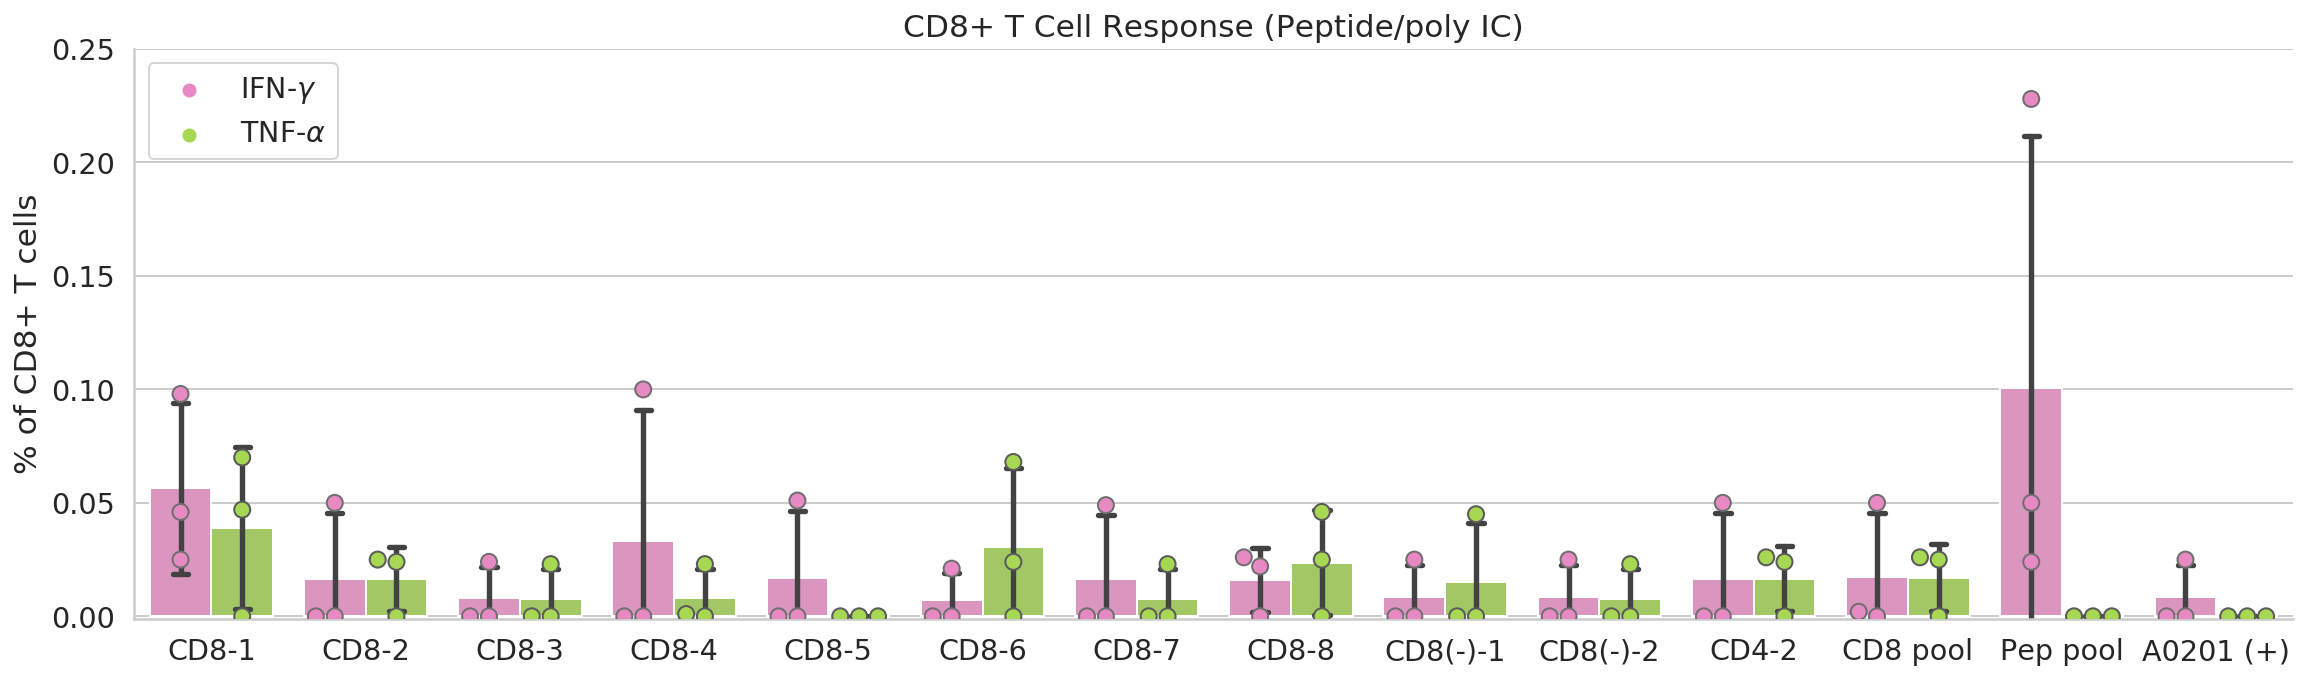

In [64]:
# Combined CD8 plot for Peptide/poly IC.

sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD8'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa',
    kind='bar',
    errorbar='sd',
    aspect=3,
    capsize=0.1,
    palette=sns.color_palette('Set2')[3:5],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD8'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa',
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[3:5],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2], loc='upper left')
ax2.set_ylim([-0.001, 0.25])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD8+ T cells')
ax2.set_title(r'CD8+ T Cell Response (Peptide/poly IC)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_PeptidePolyIC_CD8.pdf')
plt.show()

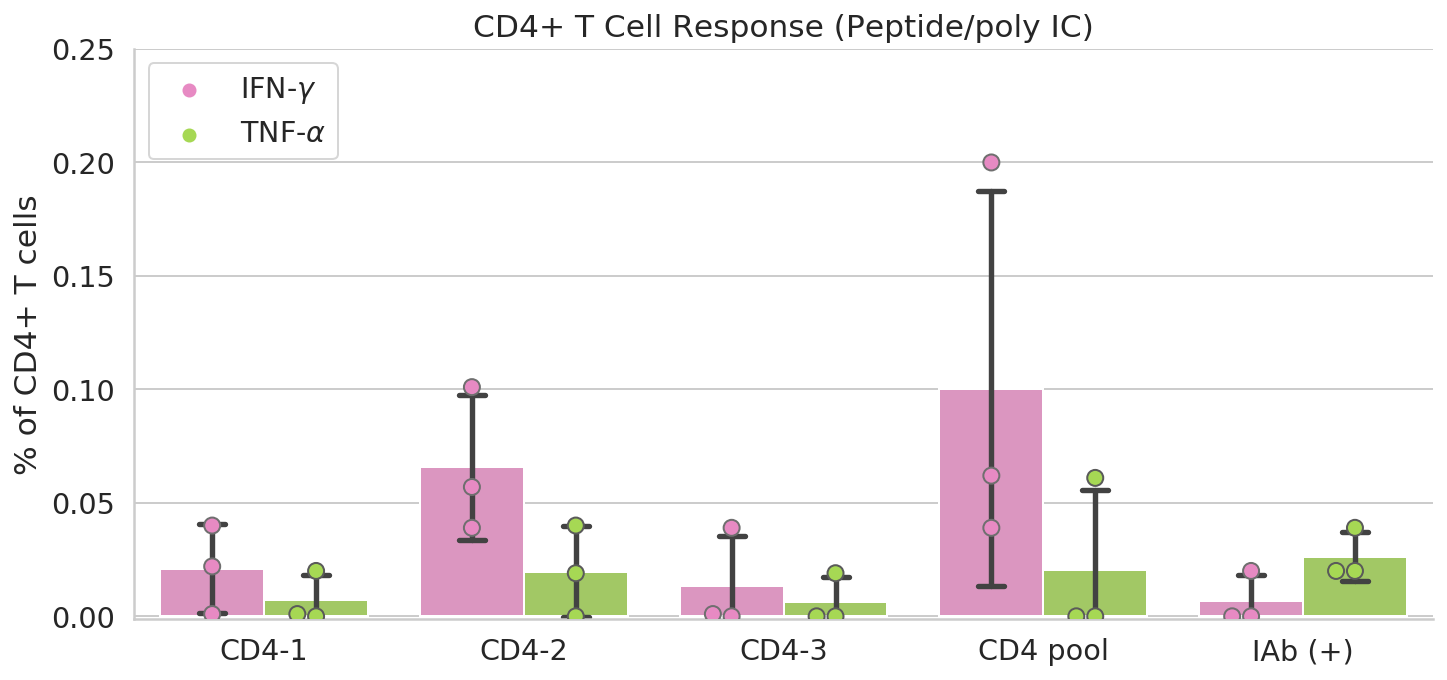

In [63]:
# Combined CD4 plot for Peptide/poly IC.

sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD4'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa',
    kind='bar',
    errorbar='sd',
    aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[3:5],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD4'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa',
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[3:5],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2], loc='upper left')
ax2.set_ylim([-0.001, 0.25])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD4+ T cells')
ax2.set_title(r'CD4+ T Cell Response (Peptide/poly IC)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_PeptidePolyIC_CD4.pdf')
plt.show()

# Peptide/poly IC Immunogenicity - with IL2

In [40]:
# Create combined table of CD4/CD8 and IFNr/TNFa/IL2 for a single supplemental figure.

immunogenicity_CD4_TNFa_df_peppolyic = immunogenicity_CD4_TNFa_df_all.loc[immunogenicity_CD4_TNFa_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD4_TNFa_df_peppolyic['CD8/CD4'] = 'CD4'
immunogenicity_CD4_TNFa_df_peppolyic['IFNr/TNFa/IL2'] = 'TNFa'

immunogenicity_CD4_IFNr_df_peppolyic = immunogenicity_CD4_IFNr_df_all.loc[immunogenicity_CD4_IFNr_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD4_IFNr_df_peppolyic['CD8/CD4'] = 'CD4'
immunogenicity_CD4_IFNr_df_peppolyic['IFNr/TNFa/IL2'] = 'IFNr'

immunogenicity_CD4_IL2_df_peppolyic = immunogenicity_CD4_IL2_df_all.loc[immunogenicity_CD4_IL2_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD4_IL2_df_peppolyic['CD8/CD4'] = 'CD4'
immunogenicity_CD4_IL2_df_peppolyic['IFNr/TNFa/IL2'] = 'IL2'

immunogenicity_CD8_TNFa_df_peppolyic = immunogenicity_CD8_TNFa_df_all.loc[immunogenicity_CD8_TNFa_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD8_TNFa_df_peppolyic['CD8/CD4'] = 'CD8'
immunogenicity_CD8_TNFa_df_peppolyic['IFNr/TNFa/IL2'] = 'TNFa'

immunogenicity_CD8_IFNr_df_peppolyic = immunogenicity_CD8_IFNr_df_all.loc[immunogenicity_CD8_IFNr_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD8_IFNr_df_peppolyic['CD8/CD4'] = 'CD8'
immunogenicity_CD8_IFNr_df_peppolyic['IFNr/TNFa/IL2'] = 'IFNr'

immunogenicity_CD8_IL2_df_peppolyic = immunogenicity_CD8_IL2_df_all.loc[immunogenicity_CD8_IL2_df_all['Vaccine'] == 'Peptide/poly IC'].copy()
immunogenicity_CD8_IL2_df_peppolyic['CD8/CD4'] = 'CD8'
immunogenicity_CD8_IL2_df_peppolyic['IFNr/TNFa/IL2'] = 'IL2'

immunogenicity_combined_peppolyic = pd.concat([
    immunogenicity_CD4_IFNr_df_peppolyic,
    immunogenicity_CD4_TNFa_df_peppolyic,
    immunogenicity_CD4_IL2_df_peppolyic,
    immunogenicity_CD8_IFNr_df_peppolyic,
    immunogenicity_CD8_TNFa_df_peppolyic,
    immunogenicity_CD8_IL2_df_peppolyic,
])
immunogenicity_combined_peppolyic

,Vaccine,ID,variable,value,value %,CD8/CD4,IFNr/TNFa/IL2
0,Peptide/poly IC,Peptide/poly IC-1,CD4-1,0.00040,0.040,CD4,IFNr
1,Peptide/poly IC,Peptide/poly IC-2,CD4-1,0.00022,0.022,CD4,IFNr
2,Peptide/poly IC,Peptide/poly IC-3,CD4-1,0.00001,0.001,CD4,IFNr
12,Peptide/poly IC,Peptide/poly IC-1,CD4-2,0.00057,0.057,CD4,IFNr
13,Peptide/poly IC,Peptide/poly IC-2,CD4-2,0.00101,0.101,CD4,IFNr
...,...,...,...,...,...,...,...
145,Peptide/poly IC,Peptide/poly IC-2,Pep pool,0.00000,0.000,CD8,IL2
146,Peptide/poly IC,Peptide/poly IC-3,Pep pool,0.00000,0.000,CD8,IL2
156,Peptide/poly IC,Peptide/poly IC-1,A0201 (+),0.00000,0.000,CD8,IL2
157,Peptide/poly IC,Peptide/poly IC-2,A0201 (+),0.00046,0.046,CD8,IL2


In [41]:
immunogenicity_combined_peppolyic.groupby(['CD8/CD4', 'IFNr/TNFa/IL2', 'Vaccine', 'variable']).agg(
    ['count', 'mean', 'median', 'std'])[['value %']]

value %                   \
                                                  count      mean median   
CD8/CD4 IFNr/TNFa/IL2 Vaccine         variable                             
CD4     IFNr          Peptide/poly IC CD4 pool        3  0.100333  0.062   
                                      CD4-1           3  0.021000  0.022   
                                      CD4-2           3  0.065667  0.057   
                                      CD4-3           3  0.013333  0.001   
                                      IAb (+)         3  0.006667  0.000   
        IL2           Peptide/poly IC CD4 pool        3  0.033000  0.019   
                                      CD4-1           3  0.033333  0.039   
                                      CD4-2           3  0.072000  0.077   
                                      CD4-3           3  0.039000  0.058   
                                      IAb (+)         3  0.039333  0.039   
        TNFa          Peptide/poly IC CD4 pool        3  0.020333  0.000   
                                      CD4-1           3  0.007000  0.001   
                                      CD4-2           3  0.019667  0.019   
                                      CD4-3           3  0.006333  0.000   
                                      IAb (+)         3  0.026333  0.020   
CD8     IFNr          Peptide/poly IC A0201 (+)       3  0.008333  0.000   
                                      CD4-2           3  0.016667  0.000   
                                      CD8 pool        3  0.017333  0.002   
                                      CD8(-)-1        3  0.008333  0.000   
                                      CD8(-)-2        3  0.008333  0.000   
                                      CD8-1           3  0.056333  0.046   
                                      CD8-2           3  0.016667  0.000   
                                      CD8-3           3  0.008000  0.000   
                                      CD8-4           3  0.033333  0.000   
                                      CD8-5           3  0.017000  0.000   
                                      CD8-6           3  0.007000  0.000   
                                      CD8-7           3  0.016333  0.000   
                                      CD8-8           3  0.016000  0.022   
                                      Pep pool        3  0.100667  0.050   
        IL2           Peptide/poly IC A0201 (+)       3  0.015333  0.000   
                                      CD4-2           3  0.008000  0.000   
                                      CD8 pool        3  0.000000  0.000   
                                      CD8(-)-1        3  0.049667  0.024   
                                      CD8(-)-2        3  0.015667  0.023   
                                      CD8-1           3  0.016000  0.000   
                                      CD8-2           3  0.000000  0.000   
                                      CD8-3           3  0.023333  0.023   
                                      CD8-4           3  0.016667  0.001   
                                      CD8-5           3  0.000000  0.000   
                                      CD8-6           3  0.015333  0.022   
                                      CD8-7           3  0.015667  0.000   
                                      CD8-8           3  0.016333  0.000   
                                      Pep pool        3  0.008333  0.000   
        TNFa          Peptide/poly IC A0201 (+)       3  0.000000  0.000   
                                      CD4-2           3  0.016667  0.024   
                                      CD8 pool        3  0.017000  0.025   
                                      CD8(-)-1        3  0.015000  0.000   
                                      CD8(-)-2        3  0.007667  0.000   
                                      CD8-1           3  0.039000  0.047   
                                      CD8-2           3  0.016333  0.024   
                    

In [49]:
immunogenicity_combined_peppolyic.loc[immunogenicity_combined_peppolyic['IFNr/TNFa/IL2']=='IL2'].groupby(['CD8/CD4', 'IFNr/TNFa/IL2', 'Vaccine', 'variable']).agg(
    ['count', 'mean', 'median', 'std'])[['value %']]

value %                   \
                                                  count      mean median   
CD8/CD4 IFNr/TNFa/IL2 Vaccine         variable                             
CD4     IL2           Peptide/poly IC CD4 pool        3  0.033000  0.019   
                                      CD4-1           3  0.033333  0.039   
                                      CD4-2           3  0.072000  0.077   
                                      CD4-3           3  0.039000  0.058   
                                      IAb (+)         3  0.039333  0.039   
CD8     IL2           Peptide/poly IC A0201 (+)       3  0.015333  0.000   
                                      CD4-2           3  0.008000  0.000   
                                      CD8 pool        3  0.000000  0.000   
                                      CD8(-)-1        3  0.049667  0.024   
                                      CD8(-)-2        3  0.015667  0.023   
                                      CD8-1           3  0.016000  0.000   
                                      CD8-2           3  0.000000  0.000   
                                      CD8-3           3  0.023333  0.023   
                                      CD8-4           3  0.016667  0.001   
                                      CD8-5           3  0.000000  0.000   
                                      CD8-6           3  0.015333  0.022   
                                      CD8-7           3  0.015667  0.000   
                                      CD8-8           3  0.016333  0.000   
                                      Pep pool        3  0.008333  0.000   

                                                           
                                                      std  
CD8/CD4 IFNr/TNFa/IL2 Vaccine         variable             
CD4     IL2           Peptide/poly IC CD4 pool   0.040841  
                                      CD4-1      0.029905  
                                      CD4-2      0.031796  
                                      CD4-3      0.032909  
                                      IAb (+)    0.039501  
CD8     IL2           Peptide/poly IC A0201 (+)  0.026558  
                                      CD4-2      0.013856  
                                      CD8 pool   0.000000  
                                      CD8(-)-1   0.066335  
                                      CD8(-)-2   0.013577  
                                      CD8-1      0.027713  
                                      CD8-2      0.000000  
                                      CD8-3      0.023502  
                                      CD8-4      0.028006  
                                      CD8-5      0.000000  
                                      CD8-6      0.013317  
                                      CD8-7      0.027135  
                                      CD8-8      0.028290  
                                      Pep pool   0.014434

In [42]:
# Add LaTeX formatting for IFNr/TNFa
immunogenicity_combined_peppolyic_forplot = immunogenicity_combined_peppolyic.copy()
immunogenicity_combined_peppolyic_forplot['IFNr/TNFa/IL2'] = immunogenicity_combined_peppolyic_forplot['IFNr/TNFa/IL2'].replace(
    {'TNFa': r'TNF-$\alpha$', 'IFNr': r'IFN-$\gamma$', 'IL2': r'IL-2'})
immunogenicity_combined_peppolyic_forplot

,Vaccine,ID,variable,value,value %,CD8/CD4,IFNr/TNFa/IL2
0,Peptide/poly IC,Peptide/poly IC-1,CD4-1,0.00040,0.040,CD4,IFN-$\gamma$
1,Peptide/poly IC,Peptide/poly IC-2,CD4-1,0.00022,0.022,CD4,IFN-$\gamma$
2,Peptide/poly IC,Peptide/poly IC-3,CD4-1,0.00001,0.001,CD4,IFN-$\gamma$
12,Peptide/poly IC,Peptide/poly IC-1,CD4-2,0.00057,0.057,CD4,IFN-$\gamma$
13,Peptide/poly IC,Peptide/poly IC-2,CD4-2,0.00101,0.101,CD4,IFN-$\gamma$
...,...,...,...,...,...,...,...
145,Peptide/poly IC,Peptide/poly IC-2,Pep pool,0.00000,0.000,CD8,IL-2
146,Peptide/poly IC,Peptide/poly IC-3,Pep pool,0.00000,0.000,CD8,IL-2
156,Peptide/poly IC,Peptide/poly IC-1,A0201 (+),0.00000,0.000,CD8,IL-2
157,Peptide/poly IC,Peptide/poly IC-2,A0201 (+),0.00046,0.046,CD8,IL-2


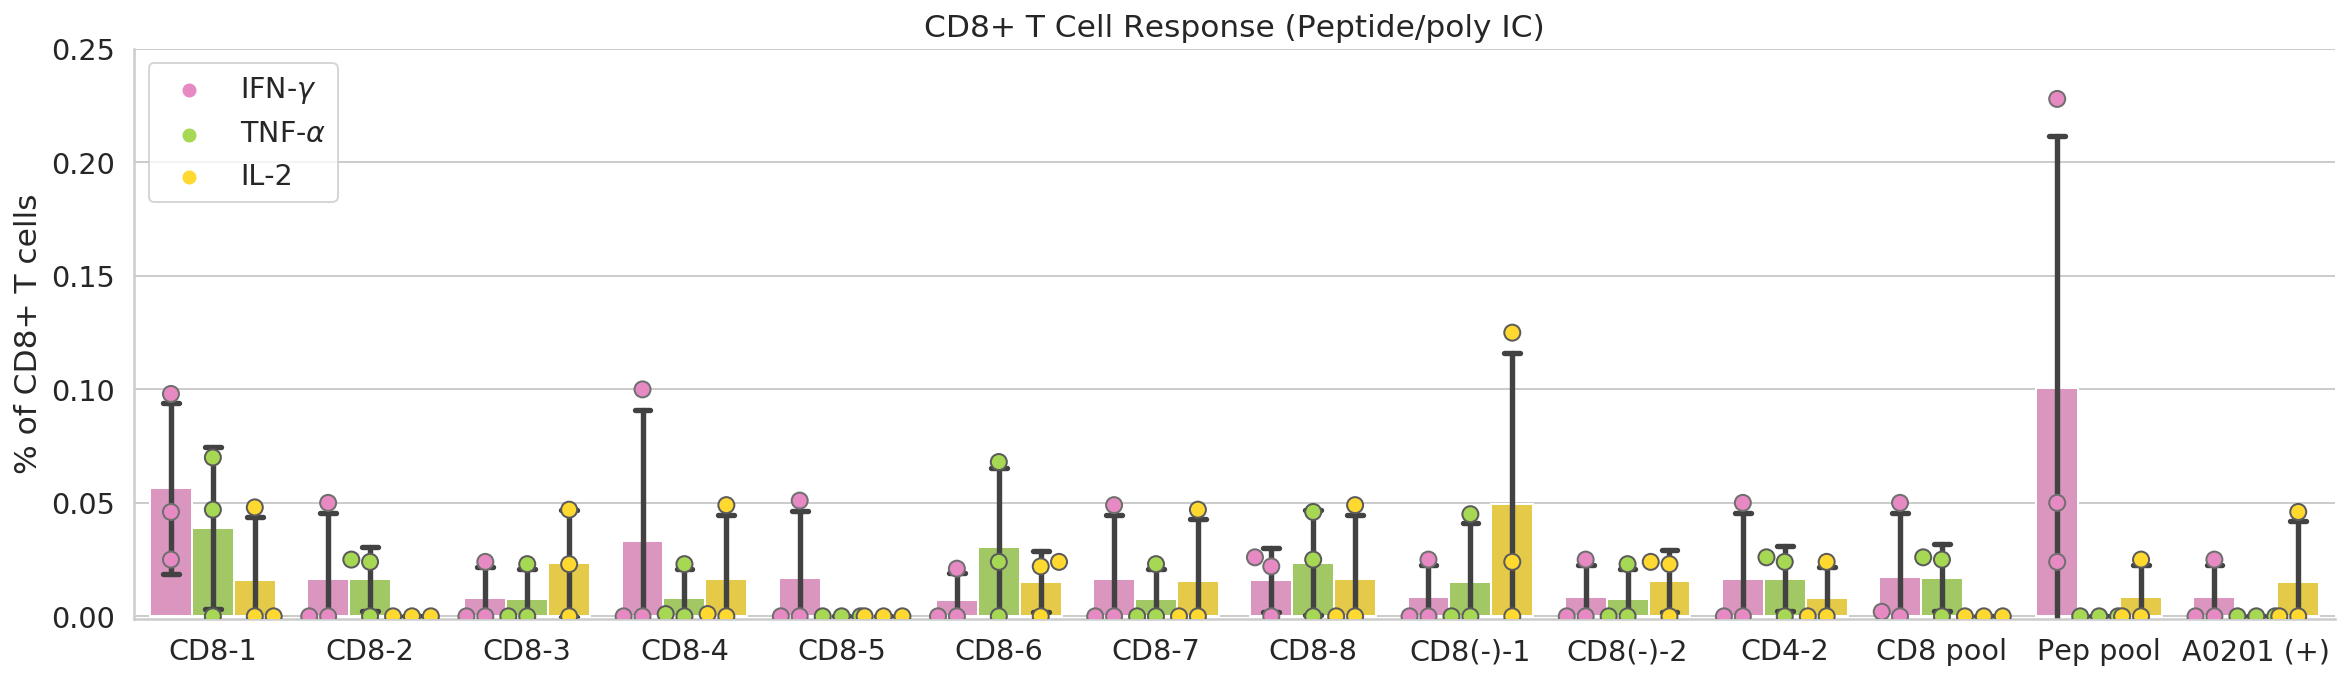

In [63]:
# Combined CD8 plot for Peptide/poly IC.

sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD8'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa/IL2',
    kind='bar',
    errorbar='sd',
    aspect=3,
    capsize=0.1,
    palette=sns.color_palette('Set2')[3:6],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD8'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa/IL2',
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[3:6],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3], loc='upper left')
ax2.set_ylim([-0.001, 0.25])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD8+ T cells')
ax2.set_title(r'CD8+ T Cell Response (Peptide/poly IC)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_PeptidePolyIC_withIL2_CD8.pdf')
plt.show()

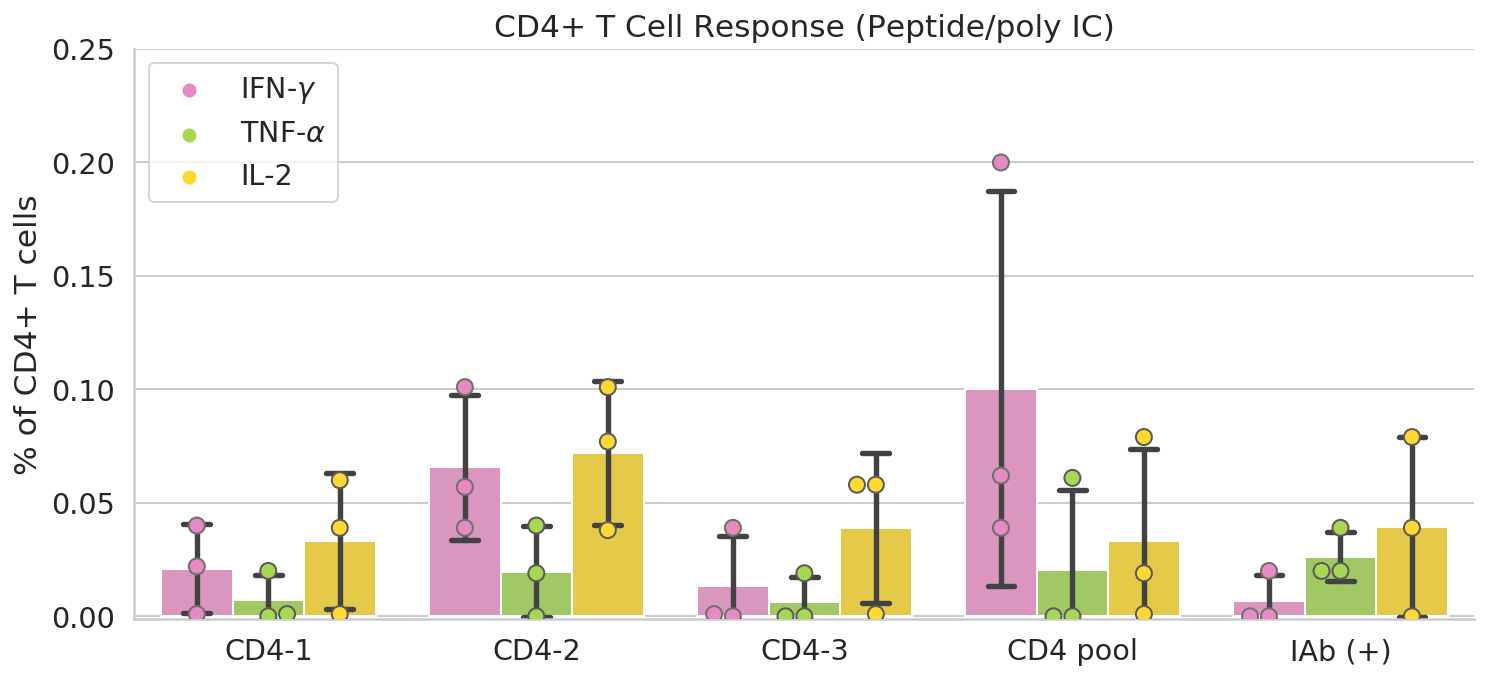

In [64]:
# Combined CD4 plot for Peptide/poly IC.

sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD4'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa/IL2',
    kind='bar',
    errorbar='sd',
    aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[3:6],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_combined_peppolyic_forplot.loc[immunogenicity_combined_peppolyic_forplot['CD8/CD4'] == 'CD4'],
    x='variable',
    y='value %',
    hue='IFNr/TNFa/IL2',
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[3:6],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3], loc='upper left')
ax2.set_ylim([-0.001, 0.25])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('% of CD4+ T cells')
ax2.set_title(r'CD4+ T Cell Response (Peptide/poly IC)')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_PeptidePolyIC_withIL2_CD4.pdf')
plt.show()

# CD44+ Analysis

In [65]:
immunogenicity_CD44_data = pd.read_csv('data/immunogenicity_female_cohort/immunogenicity_test2_CD44.csv')
immunogenicity_CD44_data

,Vaccine,ID,CD4+ CD44+,CD8+ CD44+
0,Peptide/poly IC,Peptide/poly IC-1,0.227,0.355
1,Peptide/poly IC,Peptide/poly IC-2,0.290,0.434
2,Peptide/poly IC,Peptide/poly IC-3,0.282,0.468
3,Pfizer/BNT,BNT-1,0.257,0.528
4,Pfizer/BNT,BNT-2,0.275,0.593
5,Pfizer/BNT,BNT-3,0.293,0.554
6,MIT,MIT-1,0.354,0.582
7,MIT,MIT-2,0.289,0.533
8,MIT,MIT-3,0.271,0.542
9,PBS,PBS-1,0.205,0.339


In [69]:
immunogenicity_CD44_df = pd.melt(
    immunogenicity_CD44_data,
    id_vars=['Vaccine', 'ID'],
    value_vars=['CD4+ CD44+', 'CD8+ CD44+'],
)
immunogenicity_CD44_df['value %'] = immunogenicity_CD44_df['value'] * 100.

# Compute mean/standard deviation of each group.
immunogenicity_CD44_df.groupby(['variable', 'Vaccine']).agg(['count', 'mean', 'median', 'std'])[['value %']].round(decimals=3)

value %                      
                             count    mean median    std
variable   Vaccine                                      
CD4+ CD44+ MIT                   3  30.467   28.9  4.366
           PBS                   3  26.267   28.6  5.024
           Peptide/poly IC       3  26.633   28.2  3.430
           Pfizer/BNT            3  27.500   27.5  1.800
CD8+ CD44+ MIT                   3  55.233   54.2  2.608
           PBS                   3  37.367   37.9  3.233
           Peptide/poly IC       3  41.900   43.4  5.797
           Pfizer/BNT            3  55.833   55.4  3.272

In [70]:
immunogenicity_CD44_df

,Vaccine,ID,variable,value,value %
0,Peptide/poly IC,Peptide/poly IC-1,CD4+ CD44+,0.227,22.7
1,Peptide/poly IC,Peptide/poly IC-2,CD4+ CD44+,0.290,29.0
2,Peptide/poly IC,Peptide/poly IC-3,CD4+ CD44+,0.282,28.2
3,Pfizer/BNT,BNT-1,CD4+ CD44+,0.257,25.7
4,Pfizer/BNT,BNT-2,CD4+ CD44+,0.275,27.5
5,Pfizer/BNT,BNT-3,CD4+ CD44+,0.293,29.3
6,MIT,MIT-1,CD4+ CD44+,0.354,35.4
7,MIT,MIT-2,CD4+ CD44+,0.289,28.9
8,MIT,MIT-3,CD4+ CD44+,0.271,27.1
9,PBS,PBS-1,CD4+ CD44+,0.205,20.5


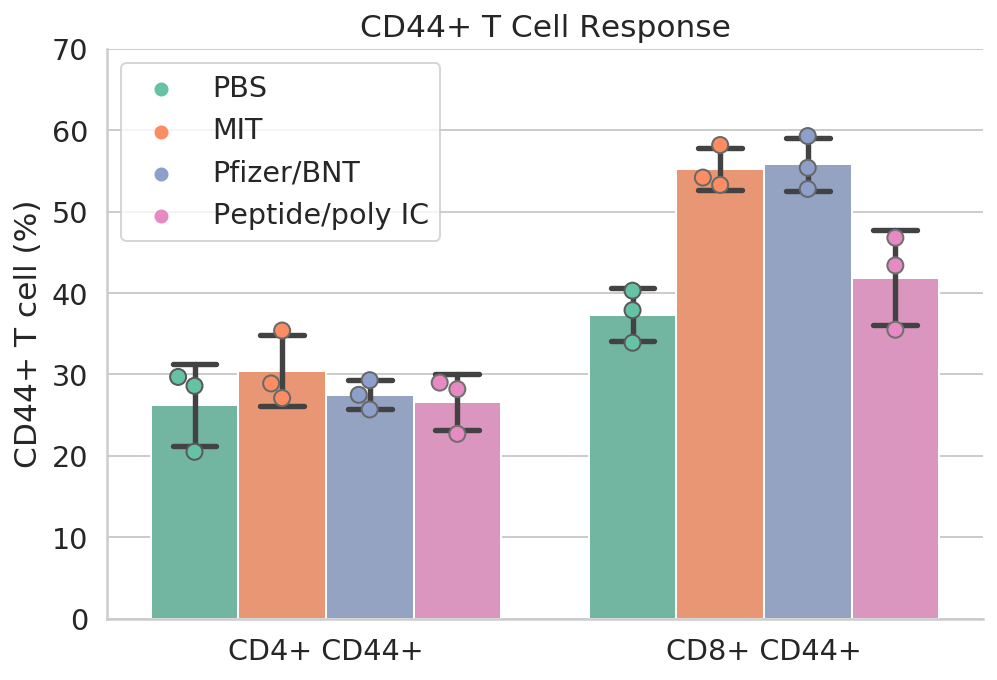

In [82]:
#sns.set(font_scale=1.3, style='whitegrid')
ax1 = sns.catplot(
    data=immunogenicity_CD44_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT', 'Peptide/poly IC'],
    kind='bar',
    errorbar='sd',
    #aspect=1.8,
    capsize=0.1,
    palette=sns.color_palette('Set2')[:4],
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=immunogenicity_CD44_df,
    x='variable',
    y='value %',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT', 'Peptide/poly IC'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2')[:4],
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:4], labels[:4])
ax2.set_ylim([0, 70])
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('CD44+ T cell (%)')
ax2.set_title('CD44+ T Cell Response')
plt.tight_layout()
plt.savefig('figures/immunogenicity_test2_CD44.pdf')
plt.show()

In [80]:
# Compute statistics for CD44+ (only PBS/MIT/Pfizer-BNT)

immunogenicity_data = immunogenicity_CD44_df.loc[immunogenicity_CD44_df['Vaccine'].isin(['PBS', 'MIT', 'Pfizer/BNT'])]

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()

Statistics for query peptide:  CD4+ CD44+
Total data points (all groups):  9
Data PBS:  [20.5, 28.6, 29.7]
Data MIT:  [35.4, 28.9, 27.1]
Data Pfizer/BNT:  [25.7, 27.500000000000004, 29.299999999999997]
F_onewayResult(statistic=0.8821508693213684, pvalue=0.4614732557562808)
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1   group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------
   MIT        PBS     -4.2 0.4502 -14.1619  5.7619  False
   MIT Pfizer/BNT  -2.9667 0.6474 -12.9285  6.9952  False
   PBS Pfizer/BNT   1.2333    0.9  -8.7285 11.1952  False
---------------------------------------------------------


Statistics for query peptide:  CD8+ CD44+
Total data points (all groups):  9
Data PBS:  [33.9, 40.3, 37.9]
Data MIT:  [58.20000000000001, 53.29999999999999, 54.2]
Data Pfizer/BNT:  [52.800000000000004, 59.3, 55.39999999999999]
F_onewayResult(statistic=35.439675727229485, pvalue=0.0004753621712132069)
   Multiple Comp

In [81]:
# Compute statistics for CD44+ (including Peptide/poly IC)

immunogenicity_data = immunogenicity_CD44_df

for query in immunogenicity_data['variable'].drop_duplicates().values.tolist():
    print('Statistics for query peptide: ', query)
    data_query = immunogenicity_data.loc[immunogenicity_data['variable'] == query]
    print('Total data points (all groups): ', len(data_query))

    # One-way ANOVA
    data_query_PBS = data_query.loc[data_query['Vaccine'] == 'PBS']['value %'].values.tolist()
    data_query_MIT = data_query.loc[data_query['Vaccine'] == 'MIT']['value %'].values.tolist()
    data_query_BNT = data_query.loc[data_query['Vaccine'] == 'Pfizer/BNT']['value %'].values.tolist()
    data_query_PeptidePolyIC = data_query.loc[data_query['Vaccine'] == 'Peptide/poly IC']['value %'].values.tolist()
    print('Data PBS: ', data_query_PBS)
    print('Data MIT: ', data_query_MIT)
    print('Data Pfizer/BNT: ', data_query_BNT)
    print('Data Peptide/poly IC: ', data_query_PeptidePolyIC)
    print(f_oneway(data_query_PBS, data_query_MIT, data_query_BNT, data_query_PeptidePolyIC))

    # Tukey HSD
    print(pairwise_tukeyhsd(
        endog=data_query['value %'],
        groups=data_query['Vaccine'],
        alpha=0.05,
    ))

    print()
    print()


Statistics for query peptide:  CD4+ CD44+
Total data points (all groups):  12
Data PBS:  [20.5, 28.6, 29.7]
Data MIT:  [35.4, 28.9, 27.1]
Data Pfizer/BNT:  [25.7, 27.500000000000004, 29.299999999999997]
Data Peptide/poly IC:  [22.7, 28.999999999999996, 28.199999999999996]
F_onewayResult(statistic=0.7341463871559981, pvalue=0.5603175150919897)
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------
            MIT             PBS     -4.2 0.5643 -14.2694  5.8694  False
            MIT Peptide/poly IC  -3.8333  0.624 -13.9027   6.236  False
            MIT      Pfizer/BNT  -2.9667  0.765  -13.036  7.1027  False
            PBS Peptide/poly IC   0.3667    0.9  -9.7027  10.436  False
            PBS      Pfizer/BNT   1.2333    0.9   -8.836 11.3027  False
Peptide/poly IC      Pfizer/BNT   0.8667    0.9  -9.2027  10.936  False
-------

# Lung IHC Cell Counting (CD8+/CD4+ Side by Side Images) - Non-infected female cohort

Analyze output of running CellProfiler

For each vaccine group:
* Photo No. 1&2 are from mice 1
* No. 3,4,5 and 6 are from mice 2
* No. 7, 8, 9 and 10 from mice 3

In [83]:
# Load data from CellProfiler output (this is the Image.csv file).
lung_ihc_cellcount_data_cd4cd8side_all = pd.read_csv('data/lung_IHC_cellprofiler/Image_CD4CD8_FemaleCohort_110922.csv')

lung_ihc_cellcount_data_cd4cd8side = lung_ihc_cellcount_data_cd4cd8side_all[['Count_CD4CD8Cells', 'Count_Nuclei']]
lung_ihc_cellcount_data_cd4cd8side = lung_ihc_cellcount_data_cd4cd8side.astype(int)

# Compute fraction of total cells that are CD4/CD8.
lung_ihc_cellcount_data_cd4cd8side['CD4CD8_Percentage'] = (
    lung_ihc_cellcount_data_cd4cd8side['Count_CD4CD8Cells'] / lung_ihc_cellcount_data_cd4cd8side['Count_Nuclei']) * 100.

lung_ihc_cellcount_data_cd4cd8side['FileName'] = lung_ihc_cellcount_data_cd4cd8side_all['FileName_Lung'].apply(lambda x: x.replace('.tif', ''))
lung_ihc_cellcount_data_cd4cd8side['Vaccine'] = lung_ihc_cellcount_data_cd4cd8side['FileName'].apply(lambda x: x[:3])
lung_ihc_cellcount_data_cd4cd8side['Vaccine'] = lung_ihc_cellcount_data_cd4cd8side['Vaccine'].replace('BNT', 'Pfizer/BNT')
lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] = lung_ihc_cellcount_data_cd4cd8side['FileName'].apply(lambda x: 'CD4+' if 'CD4' in x else 'CD8+')

lung_ihc_cellcount_data_cd4cd8side.set_index(['Vaccine', 'CD4/CD8', 'FileName']).round(decimals=3)

Count_CD4CD8Cells  Count_Nuclei  \
Vaccine    CD4/CD8 FileName                                      
Pfizer/BNT CD4+    BNT CD4 1                   1          1125   
                   BNT CD4 10                 13          1400   
                   BNT CD4 2                   0          1355   
                   BNT CD4 3                   2          1447   
                   BNT CD4 4                   0          1376   
                   BNT CD4 5                   0          1440   
                   BNT CD4 6                  13          1197   
                   BNT CD4 7                   9          1521   
                   BNT CD4 8                   5          1464   
                   BNT CD4 9                  28          1541   
           CD8+    BNT CD8 1                   1          1198   
                   BNT CD8 10                 20          1464   
                   BNT CD8 2                   0          1396   
                   BNT CD8 3                  16          1544   
                   BNT CD8 4                  26          1475   
                   BNT CD8 5                  13          1582   
                   BNT CD8 6                   7          1389   
                   BNT CD8 7                   9          1232   
                   BNT CD8 8                  16          1499   
                   BNT CD8 9                  18          1365   
MIT        CD4+    MIT CD4 1                   0          1388   
                   MIT CD4 10                  7          1412   
                   MIT CD4 2                   0          1175   
                   MIT CD4 3                   4          1190   
                   MIT CD4 4                   1          1132   
                   MIT CD4 5                   1          1368   
                   MIT CD4 6                   7          1297   
                   MIT CD4 7                   0          1272   
                   MIT CD4 8                  46          1484   
                   MIT CD4 9                  37          1499   
           CD8+    MIT CD8 1                   5          1104   
                   MIT CD8 10                 29          1303   
                   MIT CD8 2                  10          1328   
                   MIT CD8 3                  18          1481   
                   MIT CD8 4                  18          1291   
                   MIT CD8 5                   4          1284   
                   MIT CD8 6                  14          1328   
                   MIT CD8 7                  10          1458   
                   MIT CD8 8                  16           951   
                   MIT CD8 9                  16          1115   
PBS        CD4+    PBS CD4 1                   4          1299   
                   PBS CD4 10                 18          1316   
                   PBS CD4 2                   4          1497   
                   PBS CD4 3                   1          1452   
                   PBS CD4 4                   0          1304   
                   PBS CD4 5                   0          1337   
                   PBS CD4 6                   0          1427   
                   PBS CD4 7                   3          1207   
                   PBS CD4 8                   3          1208   
                   PBS CD4 9                  12          1402   
           CD8+    PBS CD8 1                   0          1136   
                   PBS CD8 10                  2          1349   
                   PBS CD8 2                   2          1190   
                   PBS CD8 3                   4          1307   
                   PBS CD8 4                   1          1316   
                   PBS CD8 5                   1          1275   
                   PBS CD8 6                   1          1308   
                   PBS CD8 7                   0          1322   
                   PBS CD8 8                   0          1154   
     

In [85]:
# Compute mean/standard deviation of each group.
lung_ihc_cellcount_data_cd4cd8side.groupby(['CD4/CD8', 'Vaccine']).agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']).round(decimals=3)

Count_CD4CD8Cells                               \
                               count  mean median     std min max   
CD4/CD8 Vaccine                                                     
CD4+    MIT                       10  10.3    2.5  16.800   0  46   
        PBS                       10   4.5    3.0   5.930   0  18   
        Pfizer/BNT                10   7.1    3.5   8.999   0  28   
CD8+    MIT                       10  14.0   15.0   7.288   4  29   
        PBS                       10   1.1    1.0   1.287   0   4   
        Pfizer/BNT                10  12.6   14.5   8.329   0  26   

                   Count_Nuclei                                       \
                          count    mean  median      std   min   max   
CD4/CD8 Vaccine                                                        
CD4+    MIT                  10  1321.7  1332.5  129.272  1132  1499   
        PBS                  10  1344.9  1326.5   98.342  1207  1497   
        Pfizer/BNT           10  1386.6  1420.0  133.361  1125  1541   
CD8+    MIT                  10  1264.3  1297.0  163.753   951  1481   
        PBS                  10  1286.6  1307.5  108.565  1136  1509   
        Pfizer/BNT           10  1414.4  1430.0  125.476  1198  1582   

                   CD4CD8_Percentage                                     
                               count   mean median    std    min    max  
CD4/CD8 Vaccine                                                          
CD4+    MIT                       10  0.710  0.212  1.122  0.000  3.100  
        PBS                       10  0.336  0.248  0.443  0.000  1.368  
        Pfizer/BNT                10  0.499  0.240  0.610  0.000  1.817  
CD8+    MIT                       10  1.121  1.135  0.591  0.312  2.226  
        PBS                       10  0.085  0.076  0.099  0.000  0.306  
        Pfizer/BNT                10  0.869  0.929  0.562  0.000  1.763

/data/gl/g3/bcarter/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  if sys.path[0] == '':
/data/gl/g3/bcarter/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.


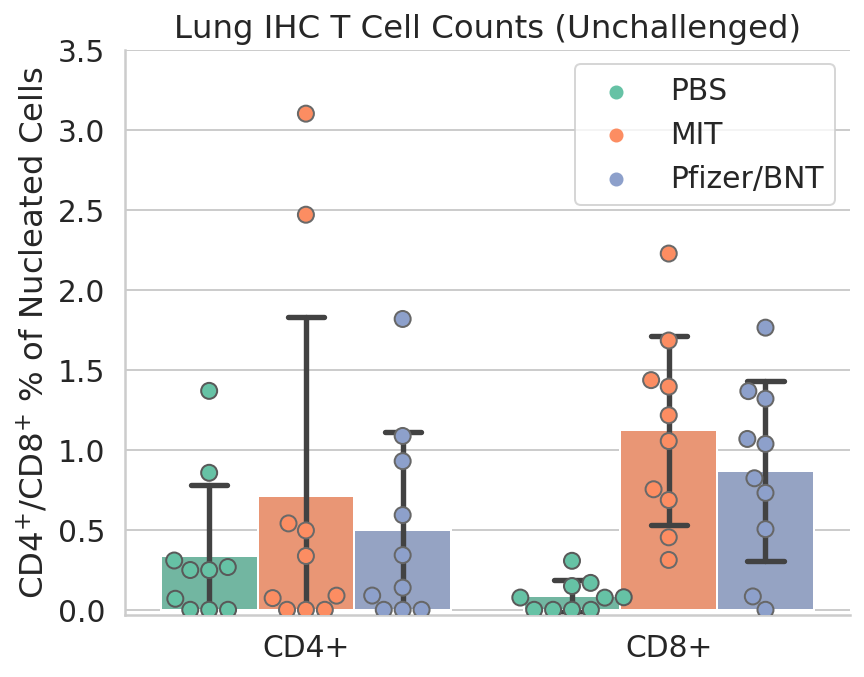

In [109]:
sns.set(font_scale=1.35, style='whitegrid')
ax1 = sns.catplot(
    data=lung_ihc_cellcount_data_cd4cd8side,
    x='CD4/CD8',
    y='CD4CD8_Percentage',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    kind='bar',
    ci='sd',
    capsize=0.1,
    #errwidth=1,
    palette=sns.color_palette('Set2'),
)
ax1._legend.remove()
ax2 = sns.swarmplot(
    data=lung_ihc_cellcount_data_cd4cd8side,
    x='CD4/CD8',
    y='CD4CD8_Percentage',
    hue='Vaccine',
    hue_order=['PBS', 'MIT', 'Pfizer/BNT'],
    dodge=True,
    size=8,
    linewidth=1,
    palette=sns.color_palette('Set2'),
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:3], labels[:3])
ax2.set_ylim([-0.03, 3.5])
ax2.set_xlabel(None)
ax2.set_ylabel(r'CD4$^{+}$/CD8$^{+}$ % of Nucleated Cells')
ax2.set_title('Lung IHC T Cell Counts (Unchallenged)')
plt.tight_layout()
plt.savefig('figures/lung_IHC_cell_counts_percentage_unchallenged_femalecohort.pdf')
plt.show()

In [92]:
# Run one-way ANOVA of Lung IHC T cell counts (as % of cells) - CD8+

lung_ihc_counts_PBS = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'PBS') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD8+')]['CD4CD8_Percentage'].values.tolist()
lung_ihc_counts_MIT = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'MIT') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD8+')]['CD4CD8_Percentage'].values.tolist()
lung_ihc_counts_BNT = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'Pfizer/BNT') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD8+')]['CD4CD8_Percentage'].values.tolist()
print('Data, PBS: ', lung_ihc_counts_PBS)
print('Data, MIT: ', lung_ihc_counts_MIT)
print('Data, Pfizer/BNT: ', lung_ihc_counts_BNT)
print()

print(f_oneway(lung_ihc_counts_PBS, lung_ihc_counts_MIT, lung_ihc_counts_BNT))

Data, PBS:  [0.0, 0.14825796886582654, 0.16806722689075632, 0.306044376434583, 0.07598784194528875, 0.0784313725490196, 0.0764525993883792, 0.0, 0.0, 0.0]
Data, MIT:  [0.4528985507246377, 2.225633154259401, 0.7530120481927711, 1.2153950033760972, 1.39426800929512, 0.3115264797507788, 1.0542168674698795, 0.6858710562414266, 1.6824395373291272, 1.4349775784753362]
Data, Pfizer/BNT:  [0.08347245409015025, 1.366120218579235, 0.0, 1.0362694300518136, 1.7627118644067796, 0.8217446270543615, 0.5039596832253419, 0.7305194805194805, 1.0673782521681119, 1.3186813186813187]

F_onewayResult(statistic=12.956438127588905, pvalue=0.0001135879666568852)


In [93]:
# Run Tukey's test of Lung IHC T cell counts (as % of cells) - CD8+

lung_ihc_cellcount_data_cd4cd8side_cd8only = lung_ihc_cellcount_data_cd4cd8side.loc[
    lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD8+']
print(len(lung_ihc_cellcount_data_cd4cd8side_cd8only))

tukey_result = pairwise_tukeyhsd(
    endog=lung_ihc_cellcount_data_cd4cd8side_cd8only['CD4CD8_Percentage'],
    groups=lung_ihc_cellcount_data_cd4cd8side_cd8only['Vaccine'],
    alpha=0.05,
)
print(tukey_result)

30
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1   group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------
   MIT        PBS  -1.0357  0.001 -1.5618 -0.5096   True
   MIT Pfizer/BNT  -0.2519 0.4723  -0.778  0.2741  False
   PBS Pfizer/BNT   0.7838 0.0028  0.2577  1.3098   True
--------------------------------------------------------


In [107]:
# Run one-way ANOVA of Lung IHC T cell counts (as % of cells) - CD4+

lung_ihc_counts_PBS = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'PBS') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD4+')]['CD4CD8_Percentage'].values.tolist()
lung_ihc_counts_MIT = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'MIT') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD4+')]['CD4CD8_Percentage'].values.tolist()
lung_ihc_counts_BNT = lung_ihc_cellcount_data_cd4cd8side.loc[
    (lung_ihc_cellcount_data_cd4cd8side['Vaccine'] == 'Pfizer/BNT') &
    (lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD4+')]['CD4CD8_Percentage'].values.tolist()
print('Data, PBS: ', lung_ihc_counts_PBS)
print('Data, MIT: ', lung_ihc_counts_MIT)
print('Data, Pfizer/BNT: ', lung_ihc_counts_BNT)
print()

print(f_oneway(lung_ihc_counts_PBS, lung_ihc_counts_MIT, lung_ihc_counts_BNT))

Data, PBS:  [0.30792917628945343, 1.3677811550151975, 0.26720106880427524, 0.06887052341597796, 0.0, 0.0, 0.0, 0.24855012427506215, 0.24834437086092717, 0.8559201141226819]
Data, MIT:  [0.0, 0.49575070821529743, 0.0, 0.33613445378151263, 0.08833922261484099, 0.07309941520467836, 0.5397070161912104, 0.0, 3.0997304582210243, 2.468312208138759]
Data, Pfizer/BNT:  [0.08888888888888889, 0.9285714285714286, 0.0, 0.138217000691085, 0.0, 0.0, 1.086048454469507, 0.591715976331361, 0.34153005464480873, 1.8170019467878002]

F_onewayResult(statistic=0.5766701929403542, pvalue=0.5685343974086658)


In [108]:
# Run Tukey's test of Lung IHC T cell counts (as % of cells) - CD4+

lung_ihc_cellcount_data_cd4cd8side_cd4only = lung_ihc_cellcount_data_cd4cd8side.loc[
    lung_ihc_cellcount_data_cd4cd8side['CD4/CD8'] == 'CD4+']
print(len(lung_ihc_cellcount_data_cd4cd8side_cd4only))

tukey_result = pairwise_tukeyhsd(
    endog=lung_ihc_cellcount_data_cd4cd8side_cd4only['CD4CD8_Percentage'],
    groups=lung_ihc_cellcount_data_cd4cd8side_cd4only['Vaccine'],
    alpha=0.05,
)
print(tukey_result)

30
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
   MIT        PBS  -0.3736 0.5389 -1.2385 0.4912  False
   MIT Pfizer/BNT  -0.2109 0.8051 -1.0758  0.654  False
   PBS Pfizer/BNT   0.1627 0.8839 -0.7021 1.0276  False
-------------------------------------------------------
